# 1. Perkenalan

## 1.1 Dataset

Dataset yang digunakan adalah dataset Predicting Coupon Redemption, yang berisi informasi mengenai penggunaan kupon diskon yang didapatkan dari beberapa tabel, yaitu tabel transaksi yang dilakukan pelanggan, tabel barang/item, tabel campaign/promosi yang dijalankan, tabel mapping kupon diskon dan barang yang didiskon, tabel demografi pelanggan, serta tabel status penggunaan/redemption suatu kupon diskon oleh pelanggan.

Link Dataset: https://www.kaggle.com/datasets/vasudeva009/predicting-coupon-redemption/data

## 1.2 Objektif

Project ini bertujuan untuk memprediksi secara tepat apakah suatu kupon diskon digunakan dalam suatu transaksi yang dilakukan oleh seorang pelanggan, agar didapatkan kupon yang baik dan efektif untuk mencapai tujuan dari promosi tersebut.

# 2. Import Libraries

In [3]:
# Setup BigQuery
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()

project_id = "buddy-session-sql"
client = bigquery.Client(project=project_id)

In [1]:
# Import libraries
import warnings
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import phik
from phik import phik_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy import stats
from scipy.stats import describe
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import f_classif
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
import pickle

In [2]:
# Filter warnings
warnings.filterwarnings('ignore')

# Tampilkan semua kolom pada dataset
pd.set_option('display.max_columns', None)

# 3. Data Loading

## 3.1 Tables Checking

In [ ]:
# Tabel campaign
campaign = pd.read_csv('campaign_data.csv')
campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   campaign_id    28 non-null     int64 
 1   campaign_type  28 non-null     object
 2   start_date     28 non-null     object
 3   end_date       28 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.0+ KB


Pada tabel campaign terdapat 28 campaign dan tidak terdapat missing values. Namun kolom start date dan end date perlu diubah menjadi bentuk datetime untuk analisa data.

In [ ]:
# Table mapping
mapping = pd.read_csv('coupon_item_mapping.csv')
mapping.info()
print('Unique Values:\n',mapping.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92663 entries, 0 to 92662
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   coupon_id  92663 non-null  int64
 1   item_id    92663 non-null  int64
dtypes: int64(2)
memory usage: 1.4 MB
Unique Values:
 coupon_id     1116
item_id      36289
dtype: int64


Terdapat 92.663 data mapping antara coupon_id dan item_id, di mana terdapat 1.116 kupon untuk 36.289 item. Sehingga setiap kupon dapat digunakan untuk beberapa item, dan setiap item dapat mendapatkan diskon dari beberapa kupon.

In [ ]:
# Tabel transaction
trx = pd.read_csv('customer_transaction_data.csv')
trx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324566 entries, 0 to 1324565
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   date             1324566 non-null  object 
 1   customer_id      1324566 non-null  int64  
 2   item_id          1324566 non-null  int64  
 3   quantity         1324566 non-null  int64  
 4   selling_price    1324566 non-null  float64
 5   other_discount   1324566 non-null  float64
 6   coupon_discount  1324566 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 70.7+ MB


Terdapat 1.324.566 data transaksi, baik yang menggunakan diskon dari kupon maupun tidak menggunakan diskon dari kupon. Tidak terdapat missing values dalam tabel ini.

In [ ]:
# Tabel item
item = pd.read_csv('item_data.csv')
item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74066 entries, 0 to 74065
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_id     74066 non-null  int64 
 1   brand       74066 non-null  int64 
 2   brand_type  74066 non-null  object
 3   category    74066 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


Terdapat 74.066 data item dan tidak terdapat missing values dalam tabel item.

In [ ]:
# Tabel redemption
redeem = pd.read_csv('train.csv')
redeem.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78369 entries, 0 to 78368
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   id                 78369 non-null  int64
 1   campaign_id        78369 non-null  int64
 2   coupon_id          78369 non-null  int64
 3   customer_id        78369 non-null  int64
 4   redemption_status  78369 non-null  int64
dtypes: int64(5)
memory usage: 3.0 MB


Terdapat 78.369 data mengenai penggunaan kupon/coupon redemption dan tidak terdapat missing values pada tabel ini.

In [ ]:
# Tabel transaction
demo = pd.read_csv('customer_demographics.csv')
demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     760 non-null    int64 
 1   age_range       760 non-null    object
 2   marital_status  431 non-null    object
 3   rented          760 non-null    int64 
 4   family_size     760 non-null    object
 5   no_of_children  222 non-null    object
 6   income_bracket  760 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 41.7+ KB


Terdapat 760 data customer, di mana terdapat missing values pada kolom marital status dan number of children. Untuk membuat tabel akhir bersih dari missing values dan untuk mengatasi missing values secara tepat, maka missing values akan diatasi sebelum menyatukan tabel akhir.

## 3.2 Handling Missing Values on Customer Demographics Data

Pada pengecekan tabel demographics, ditemui missing values pada kolom marital status dan number of children. Karena jumlah missing values pada kedua kolom ini dibandingkan dengan jumlah keseluruhan data customer cukup besar, maka missing values pada kedua kolom ini akan diimputasi berdasarkan temuan dari hasil eksplorasi data demografi customer.

In [ ]:
# Jumlah missing values pada tabel demographics
demo.isnull().sum()

customer_id         0
age_range           0
marital_status    329
rented              0
family_size         0
no_of_children    538
income_bracket      0
dtype: int64

### 3.2.1 Missing Values on Number of Children Data

In [ ]:
# Mencari apakah missing values pada kolom number of children berhubungan dengan kolom family size
demo.loc[
    (demo[['no_of_children']].isnull().any(axis=1)) &
    ((demo['family_size'] == '1') |
     (demo['family_size'] == '2'))
    ]

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
4,10,46-55,Single,0,1,NaN,5
5,11,70+,Single,0,2,NaN,1
6,12,46-55,Married,0,2,NaN,7
...,...,...,...,...,...,...,...
753,1573,46-55,Single,0,1,NaN,4
754,1574,36-45,Married,0,2,NaN,5
755,1577,36-45,NaN,0,2,NaN,5
757,1579,46-55,NaN,0,1,NaN,4


Dari hasil pengecekan missing values di atas, dapat dilihat bahwa semua missing values pada kolom number of children merupakan customer yang memiliki anggota keluarga sendiri (1) atau berdua (2). Sehingga dapat disimpulkan bahwa customer yang hidup sendiri atau berdua tidak memiliki anak, sehingga value pada kolom number of children seharusnya = 0.

In [ ]:
# Imputasi missing values number of children = 0
demo['no_of_children'].fillna(value='0',inplace=True)
demo

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,0,4
1,6,46-55,Married,0,2,0,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,0,5
...,...,...,...,...,...,...,...
755,1577,36-45,NaN,0,2,0,5
756,1578,46-55,Married,0,3,1,6
757,1579,46-55,NaN,0,1,0,4
758,1580,26-35,NaN,0,2,0,5


### 3.2.2 Missing Values on Marital Status Data

Untuk menentukan strategi imputasi data pada kolom marital status, maka hubungan marital status dengan kolom lainnya akan dieksplorasi terlebih dahulu.

In [ ]:
# Melihat apakah ada customer dengan marital status single dan memiliki anak
demo.loc[
    (demo['marital_status'] == 'Single') &
    ((demo['no_of_children'] == '1') |
     (demo['no_of_children'] == '2') |
     (demo['no_of_children'] == '3+'))
    ][['age_range','marital_status','family_size','no_of_children']]

,age_range,marital_status,family_size,no_of_children
16,36-45,Single,5+,3+
37,26-35,Single,3,2
54,36-45,Single,3,1
122,26-35,Single,2,1
196,26-35,Single,5+,3+
220,36-45,Single,3,2
239,46-55,Single,3,1
265,46-55,Single,3,2
297,46-55,Single,2,1
308,36-45,Single,2,1


In [ ]:
# Melihat status pernikahan customer yang memiliki family size = 2 tapi tidak memiliki anak
demo.loc[
    ((demo['marital_status'] == 'Married') |
     (demo['marital_status'] == 'Single')) &
    (demo['family_size'] == '2') &
    (demo['no_of_children'] == '0')
    ][['age_range','marital_status','family_size','no_of_children']]

,age_range,marital_status,family_size,no_of_children
0,70+,Married,2,0
1,46-55,Married,2,0
5,70+,Single,2,0
6,46-55,Married,2,0
8,26-35,Married,2,0
...,...,...,...,...
736,70+,Married,2,0
745,36-45,Married,2,0
746,46-55,Married,2,0
748,46-55,Single,2,0


In [ ]:
# Melihat customer yang sudah menikah, tinggal sendiri dan tidak memiliki anak
demo.loc[
    (demo['marital_status'] == 'Married') &
    (demo['family_size'] == '1') &
    (demo['no_of_children'] == '0')
    ][['age_range','marital_status','family_size','no_of_children']]

,age_range,marital_status,family_size,no_of_children


Dari hasil eksplorasi kolom marital status di atas, dapat disimpulkan bahwa customer yang tinggal sendiri (family size = 1) dan tidak memiliki anak (number of children = 0) pasti belum menikah (marital status = 'single'). Namun customer dengan family size lebih dari 1 dan number of children lebih dari 0 (memiliki anak) belum tentu marital status-nya sudah menikah atau belum menikah.

Maka, untuk data customer yang tinggal sendiri (family size = 1) dan tidak memiliki anak (number of children = 0) missing values pada marital status akan diimputasi menjadi 'Single'. Sementara untuk missing values marital status lainnya akan diimputasi menggunakan KNN Imputer.

In [ ]:
# Impute family_size = 1, no_of_children = 0 berarti marital_status = 'Single'
demo['marital_status'] = demo.apply(lambda row: 'Single' if pd.isnull(row['marital_status']) and
                                row['family_size'] == '1' and row['no_of_children'] == '0'
                                else row['marital_status'], axis=1)

demo

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,0,4
1,6,46-55,Married,0,2,0,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,0,5
...,...,...,...,...,...,...,...
755,1577,36-45,NaN,0,2,0,5
756,1578,46-55,Married,0,3,1,6
757,1579,46-55,Single,0,1,0,4
758,1580,26-35,NaN,0,2,0,5


In [ ]:
# Impute missing values lainnya

# Encode kolom marital status
demo['marital_status'] = demo['marital_status'].apply(lambda x: 0 if x == 'Single' else 1 if x == 'Married' else x)

# Impute menggunakan KNN Imputer
imputer = KNNImputer()
demo['marital_status'] = imputer.fit_transform(demo[['marital_status']])

# Bulatkan hasil KNN Imputer agar didapatkan customer Single atau Married
demo['marital_status'] = demo['marital_status'].round().astype(int)

# Decode kembali kolom marital status
demo['marital_status'] = demo['marital_status'].apply(lambda x: 'Single' if x == 0 else 'Married' if x == 1 else x)

demo

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,0,4
1,6,46-55,Married,0,2,0,5
2,7,26-35,Married,0,3,1,3
3,8,26-35,Married,0,4,2,6
4,10,46-55,Single,0,1,0,5
...,...,...,...,...,...,...,...
755,1577,36-45,Married,0,2,0,5
756,1578,46-55,Married,0,3,1,6
757,1579,46-55,Single,0,1,0,4
758,1580,26-35,Married,0,2,0,5


In [ ]:
# Simpan tabel untuk dimasukkan ke dalam BigQuery
demo.to_csv('demographics.csv')

## 3.3 Creating and Loading Final Data

In [6]:
# Membuat tabel akhir pada BigQuery

df = client.query('''
SELECT id,
  r.campaign_id,
  r.coupon_id,
  r.customer_id,
  m.item_id,
  redemption_status,
  date,
  quantity,
  selling_price,
  other_discount,
  coupon_discount,
  brand,
  brand_type,
  category,
  campaign_type,
  start_date,
  end_date,
  age_range,
  marital_status,
  rented,
  family_size,
  no_of_children,
  income_bracket
FROM `buddy-session-sql.coupon_redemption.redemption` r
JOIN `buddy-session-sql.coupon_redemption.transactions` t
ON r.customer_id = t.customer_id
JOIN `buddy-session-sql.coupon_redemption.mapping` m
ON r.coupon_id = m.coupon_id AND t.item_id = m.item_id
JOIN `buddy-session-sql.coupon_redemption.items` i
ON t.item_id = i.item_id
JOIN `buddy-session-sql.coupon_redemption.campaigns` c
ON r.campaign_id = c.campaign_id
JOIN `buddy-session-sql.coupon_redemption.demographics` d
ON r.customer_id = d.customer_id
''').to_dataframe()

df

,id,campaign_id,coupon_id,customer_id,item_id,redemption_status,date,quantity,selling_price,other_discount,coupon_discount,brand,brand_type,category,campaign_type,start_date,end_date,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,23398,3,670,1534,8772,0,2012-01-06,2,118.61,-37.40,0.0,676,Established,Grocery,Y,2012-12-22,2013-02-16,36-45,Married,0,3,1,5
1,61131,3,671,1534,8772,1,2012-01-06,2,118.61,-37.40,0.0,676,Established,Grocery,Y,2012-12-22,2013-02-16,36-45,Married,0,3,1,5
2,78314,27,671,1463,9645,0,2012-01-09,2,124.67,-31.35,0.0,676,Established,Grocery,Y,2012-08-25,2012-10-27,36-45,Married,0,5+,3+,5
3,7133,3,670,464,35412,0,2012-02-02,2,109.71,-46.31,0.0,676,Established,Grocery,Y,2012-12-22,2013-02-16,46-55,Married,0,5+,3+,3
4,15365,3,671,464,35412,0,2012-02-02,2,109.71,-46.31,0.0,676,Established,Grocery,Y,2012-12-22,2013-02-16,46-55,Married,0,5+,3+,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94850,21077,30,1003,1574,59838,0,2013-05-10,1,71.24,-35.26,0.0,1475,Established,Natural Products,X,2012-11-19,2013-01-04,36-45,Married,0,2,0,5
94851,76459,30,1003,460,67131,0,2013-05-19,1,71.24,-35.26,0.0,1475,Established,Natural Products,X,2012-11-19,2013-01-04,70+,Married,0,2,0,5
94852,15941,30,786,797,6029,0,2013-06-08,1,71.24,-35.26,0.0,946,Established,Grocery,X,2012-11-19,2013-01-04,46-55,Single,0,1,0,6
94853,128213,30,288,566,44972,0,2013-06-14,1,71.24,-35.26,0.0,25,Established,Grocery,X,2012-11-19,2013-01-04,26-35,Married,0,4,2,5


In [7]:
# Menyimpan dataset ke dalam csv
df.to_csv('coupon_redemption.csv',index=False)

In [3]:
# Load dataset yang sudah digabungkan
df = pd.read_csv('coupon_redemption.csv')

# 4. Exploratory Data Analysis (EDA)

## 4.1 Coupon Redemption Dataset Information

In [ ]:
# Informasi mengenai dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94855 entries, 0 to 94854
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 94855 non-null  int64  
 1   campaign_id        94855 non-null  int64  
 2   coupon_id          94855 non-null  int64  
 3   customer_id        94855 non-null  int64  
 4   item_id            94855 non-null  int64  
 5   redemption_status  94855 non-null  int64  
 6   date               94855 non-null  object 
 7   quantity           94855 non-null  int64  
 8   selling_price      94855 non-null  float64
 9   other_discount     94855 non-null  float64
 10  coupon_discount    94855 non-null  float64
 11  brand              94855 non-null  int64  
 12  brand_type         94855 non-null  object 
 13  category           94855 non-null  object 
 14  campaign_type      94855 non-null  object 
 15  start_date         94855 non-null  object 
 16  end_date           948

Tabel di atas merupakan informasi mengenai dataset penggunaan kupon diskon yang didapatkan dari beberapa tabel, yaitu tabel transaksi yang dilakukan pelanggan, tabel barang/item, tabel campaign/promosi yang dijalankan, tabel mapping kupon diskon dan barang yang didiskon, tabel demografi pelanggan, serta tabel status penggunaan/redemption suatu kupon diskon oleh pelanggan.




Kolom-kolom dalam dataset ini menjelaskan mengenai:

1. id: Identifier untuk setiap data redemption. Value id tidak unique di setiap baris data karena satu kupon yang digunakan seorang pelanggan dapat digunakan untuk membeli lebih dari satu jenis barang/item;
2. campaign_id: Identifier untuk setiap campaign;
3. coupon_id: Identifier untuk setiap kupon;
4. customer_id: Identifier untuk setiap pelanggan;
5. item_id: Identifier untuk setiap barang;
6. redemption_status: Status penggunaan kupon diskon, di mana 1 = kupon digunakan dan 0 = kupon tidak digunakan. Kolom ini merupakan kolom target;
7. date: Tanggal transaksi yang dilakukan pelanggan;
8. quantity: Jumlah barang yang dibeli pelanggan;
9. selling_price: Harga jual dari barang yang dibeli pelanggan;
10. other_discount: Diskon selain dari kupon diskon, di mana kolom ini bernilai negatif;
11. coupon_discount: Diskon dari kupon diskon yang digunakan, di mana kolom ini bernilai negatif;
12. brand: Brand dari barang yang dibeli, berupa integer seperti id;
13. brand_type: Tipe brand dari barang yang dibeli, apakah local atau established;
14. category: Kategori brand yang menjual barang yang dibeli, seperti grocery, dsb;
15. campaign_type: Tipe campaign atau promosi, bernilai dummy Y dan X;
16. start_date: Tanggal mulainya masa promosi/campaign;
17. end_date: Tanggal berakhir masa promosi/campaign;
18. age_range: Kelompok umur dari pelanggan;
19. marital_status: Status perkawinan pelanggan;
20. rented: Tempat tinggal pelanggan, di mana 1 = sewa/kontrak dan 0 = tidak sewa/kontrak;
21. family_size: Jumlah anggota keluarga pelanggan termasuk diri sendiri;
22. no_of_children: Jumlah anak dari pelanggan;
23. income_bracket: Tingkat pendapatan pelanggan, di mana semakin tinggi code income bracket, semakin tinggi tingkat pendapatan pelanggan tersebut.

Dalam dataset ini sudah tidak terdapat missing values karena missing values sudah diatasi sebelum penggabungan tabel-tabel yang dijadikan dataset ini. Namun beberapa kolom dalam dataset ini masih memiliki tipe data yang kurang sesuai, misalnya kolom-kolom yang terkait dengan tanggal belum berbentuk datetime. Selain itu perlu dilakukan juga pengecekan data duplikat yang ada dalam dataset.

## 4.2 Data Cleaning

### 4.2.1 Rename Columns

Untuk mempermudah analisa data, maka kolom date akan diubah menjadi trx_date untuk menandakan tanggal transaksi terjadi dan kolom brand akan diubah menjadi brand_id karena value dari kolom brand berupa angka.

In [4]:
# Mengganti nama kolom date menjadi trx_date dan brand menjadi brand_id
df.rename(columns = {'date' : 'trx_date', 'brand' : 'brand_id'}, inplace = True)
df

,id,campaign_id,coupon_id,customer_id,item_id,redemption_status,trx_date,quantity,selling_price,other_discount,coupon_discount,brand_id,brand_type,category,campaign_type,start_date,end_date,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,23398,3,670,1534,8772,0,2012-01-06,2,118.61,-37.40,0.0,676,Established,Grocery,Y,2012-12-22,2013-02-16,36-45,Married,0,3,1,5
1,61131,3,671,1534,8772,1,2012-01-06,2,118.61,-37.40,0.0,676,Established,Grocery,Y,2012-12-22,2013-02-16,36-45,Married,0,3,1,5
2,78314,27,671,1463,9645,0,2012-01-09,2,124.67,-31.35,0.0,676,Established,Grocery,Y,2012-08-25,2012-10-27,36-45,Married,0,5+,3+,5
3,7133,3,670,464,35412,0,2012-02-02,2,109.71,-46.31,0.0,676,Established,Grocery,Y,2012-12-22,2013-02-16,46-55,Married,0,5+,3+,3
4,15365,3,671,464,35412,0,2012-02-02,2,109.71,-46.31,0.0,676,Established,Grocery,Y,2012-12-22,2013-02-16,46-55,Married,0,5+,3+,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94850,21077,30,1003,1574,59838,0,2013-05-10,1,71.24,-35.26,0.0,1475,Established,Natural Products,X,2012-11-19,2013-01-04,36-45,Married,0,2,0,5
94851,76459,30,1003,460,67131,0,2013-05-19,1,71.24,-35.26,0.0,1475,Established,Natural Products,X,2012-11-19,2013-01-04,70+,Married,0,2,0,5
94852,15941,30,786,797,6029,0,2013-06-08,1,71.24,-35.26,0.0,946,Established,Grocery,X,2012-11-19,2013-01-04,46-55,Single,0,1,0,6
94853,128213,30,288,566,44972,0,2013-06-14,1,71.24,-35.26,0.0,25,Established,Grocery,X,2012-11-19,2013-01-04,26-35,Married,0,4,2,5


### 4.2.2 Cleaning Duplicated Data

In [5]:
# Cek adanya data duplikat
df.duplicated().sum()

900

Karena adanya data yang duplikat dalam dataset ini, maka data duplikat tersebut akan dihapus/drop dari dataset ini.

In [6]:
# Drop data yang duplikat
df = df.drop_duplicates()
df.duplicated().sum()

0

### 4.2.3 Changing Date Columns' Data Type

Untuk mempermudah analisis data, maka kolom yang berhubungan dengan tanggal, yaitu kolom trx_date, start_date, dan end_date, akan disesuaikan tipe datanya menjadi datetime.

In [7]:
# Mengganti tipe data menjadi datetime
df['trx_date'] = pd.to_datetime(df['trx_date'], format='%Y-%m-%d', errors='coerce')
df['start_date'] = pd.to_datetime(df['start_date'], format='%Y-%m-%d', errors='coerce')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d', errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93955 entries, 0 to 94854
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 93955 non-null  int64         
 1   campaign_id        93955 non-null  int64         
 2   coupon_id          93955 non-null  int64         
 3   customer_id        93955 non-null  int64         
 4   item_id            93955 non-null  int64         
 5   redemption_status  93955 non-null  int64         
 6   trx_date           93955 non-null  datetime64[ns]
 7   quantity           93955 non-null  int64         
 8   selling_price      93955 non-null  float64       
 9   other_discount     93955 non-null  float64       
 10  coupon_discount    93955 non-null  float64       
 11  brand_id           93955 non-null  int64         
 12  brand_type         93955 non-null  object        
 13  category           93955 non-null  object        
 14  campai

### 4.2.4 Data Validation: Coupon Usage Outside Promotion Period

Agar suatu kupon diskon valid untuk digunakan, seharusnya kupon diskon digunakan dalam periode promosi dari kupon tersebut. Maka perlu dilakukan validasi apakah semua data transaksi berada di dalam periode promo masing-masing kupon.

In [13]:
# Melihat transaksi yang berada di luar periode promosi
df.loc[
    (df['trx_date'] < df['start_date']) |
    (df['trx_date'] > df['end_date'])]

,id,campaign_id,coupon_id,customer_id,item_id,redemption_status,trx_date,quantity,selling_price,other_discount,coupon_discount,brand_id,brand_type,category,campaign_type,start_date,end_date,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,23398,3,670,1534,8772,0,2012-01-06,2,118.61,-37.40,0.0,676,Established,Grocery,Y,2012-12-22,2013-02-16,36-45,Married,0,3,1,5
1,61131,3,671,1534,8772,1,2012-01-06,2,118.61,-37.40,0.0,676,Established,Grocery,Y,2012-12-22,2013-02-16,36-45,Married,0,3,1,5
2,78314,27,671,1463,9645,0,2012-01-09,2,124.67,-31.35,0.0,676,Established,Grocery,Y,2012-08-25,2012-10-27,36-45,Married,0,5+,3+,5
3,7133,3,670,464,35412,0,2012-02-02,2,109.71,-46.31,0.0,676,Established,Grocery,Y,2012-12-22,2013-02-16,46-55,Married,0,5+,3+,3
4,15365,3,671,464,35412,0,2012-02-02,2,109.71,-46.31,0.0,676,Established,Grocery,Y,2012-12-22,2013-02-16,46-55,Married,0,5+,3+,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94850,21077,30,1003,1574,59838,0,2013-05-10,1,71.24,-35.26,0.0,1475,Established,Natural Products,X,2012-11-19,2013-01-04,36-45,Married,0,2,0,5
94851,76459,30,1003,460,67131,0,2013-05-19,1,71.24,-35.26,0.0,1475,Established,Natural Products,X,2012-11-19,2013-01-04,70+,Married,0,2,0,5
94852,15941,30,786,797,6029,0,2013-06-08,1,71.24,-35.26,0.0,946,Established,Grocery,X,2012-11-19,2013-01-04,46-55,Single,0,1,0,6
94853,128213,30,288,566,44972,0,2013-06-14,1,71.24,-35.26,0.0,25,Established,Grocery,X,2012-11-19,2013-01-04,26-35,Married,0,4,2,5


In [14]:
# Melihat transaksi yang berada di luar periode promosi dan menggunakan/redeem kupon
df.loc[
    ((df['trx_date'] < df['start_date']) |
    (df['trx_date'] > df['end_date'])) &
    (df['redemption_status'] == 1)]

,id,campaign_id,coupon_id,customer_id,item_id,redemption_status,trx_date,quantity,selling_price,other_discount,coupon_discount,brand_id,brand_type,category,campaign_type,start_date,end_date,age_range,marital_status,rented,family_size,no_of_children,income_bracket
1,61131,3,671,1534,8772,1,2012-01-06,2,118.61,-37.40,0.0,676,Established,Grocery,Y,2012-12-22,2013-02-16,36-45,Married,0,3,1,5
5,110750,27,671,464,35412,1,2012-02-02,2,109.71,-46.31,0.0,676,Established,Grocery,Y,2012-08-25,2012-10-27,46-55,Married,0,5+,3+,3
9,21822,2,347,153,16796,1,2012-02-25,1,48.80,-14.96,0.0,56,Local,Grocery,Y,2012-12-17,2013-01-18,46-55,Single,1,1,0,5
15,61131,3,671,1534,31090,1,2012-02-27,1,54.85,-23.15,0.0,676,Established,Grocery,Y,2012-12-22,2013-02-16,36-45,Married,0,3,1,5
26,61131,3,671,1534,31090,1,2012-03-18,1,54.85,-23.15,0.0,676,Established,Grocery,Y,2012-12-22,2013-02-16,36-45,Married,0,3,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94765,40351,30,872,1408,30981,1,2012-05-20,1,120.75,-10.69,0.0,1075,Established,Grocery,X,2012-11-19,2013-01-04,26-35,Single,0,1,0,9
94811,108952,30,994,1441,4913,1,2012-03-14,1,89.05,-35.26,0.0,1433,Established,Grocery,X,2012-11-19,2013-01-04,36-45,Married,0,3,1,2
94812,108952,30,994,1441,4913,1,2012-03-26,1,89.05,-35.26,0.0,1433,Established,Grocery,X,2012-11-19,2013-01-04,36-45,Married,0,3,1,2
94822,91449,30,522,1574,27633,1,2012-08-14,1,71.24,-35.26,0.0,278,Established,Grocery,X,2012-11-19,2013-01-04,36-45,Married,0,2,0,5


In [15]:
# Melihat transaksi yang berada di luar periode promosi dan menggunakan/redeem kupon serta berhasil
#  mendapatkan diskon dari kupon tersebut
df.loc[
    ((df['trx_date'] < df['start_date']) |
    (df['trx_date'] > df['end_date'])) &
    (df['redemption_status'] == 1) &
    (df['coupon_discount'] < 0)]

,id,campaign_id,coupon_id,customer_id,item_id,redemption_status,trx_date,quantity,selling_price,other_discount,coupon_discount,brand_id,brand_type,category,campaign_type,start_date,end_date,age_range,marital_status,rented,family_size,no_of_children,income_bracket
445,118034,7,986,1070,19830,1,2012-07-28,1,409.27,0.00,-35.62,1342,Established,Pharmaceutical,Y,2013-02-02,2013-03-08,56-70,Single,0,1,0,6
656,118034,7,986,1070,11224,1,2013-06-16,1,427.08,0.00,-53.43,1342,Established,Pharmaceutical,Y,2013-02-02,2013-03-08,56-70,Single,0,1,0,6
1215,118034,7,986,1070,19830,1,2012-10-28,1,398.59,-35.62,-35.62,1342,Established,Pharmaceutical,Y,2013-02-02,2013-03-08,56-70,Single,0,1,0,6
1216,118034,7,986,1070,20798,1,2012-10-28,1,640.80,-35.62,-35.62,1342,Established,Pharmaceutical,Y,2013-02-02,2013-03-08,56-70,Single,0,1,0,6
1709,34419,4,407,15,57899,1,2012-08-16,1,70.88,0.00,-35.62,58,Established,Grocery,Y,2013-01-07,2013-02-08,46-55,Married,0,2,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94430,34781,30,409,607,5668,1,2012-01-22,2,38.83,-17.45,-28.14,63,Established,Grocery,X,2012-11-19,2013-01-04,70+,Single,0,1,0,4
94620,91449,30,522,1574,58626,1,2012-08-24,1,106.50,-17.81,-35.62,971,Established,Grocery,X,2012-11-19,2013-01-04,36-45,Married,0,2,0,5
94637,108952,30,994,1441,29098,1,2012-10-22,1,284.60,-17.81,-35.62,1433,Established,Grocery,X,2012-11-19,2013-01-04,36-45,Married,0,3,1,2
94638,108952,30,994,1441,29098,1,2013-05-01,1,284.60,-17.81,-35.62,1433,Established,Grocery,X,2012-11-19,2013-01-04,36-45,Married,0,3,1,2


Terdapat 84.627 data transaksi yang tidak terjadi selama periode promosi dari masing-masing kupon, dan 13.420 di antaranya merupakan data transaksi menggunakan kupon untuk mendapatkan diskon. Dari 13.420 data transaksi di luar periode promo yang menggunakan kupon diskon, 896 di antaranya berhasil mendapatkan diskon dari promosi tersebut. Hal ini menandakan bahwa terjadi error saat input data atau error pada sistem penukaran kupon/promo sehingga terdapat pelanggan yang dapat menggunakan promo di luar periode promosi.

Data yang tidak sesuai dengan ketentuan periode promosi akan dihapus/drop walaupun jumlahnya sangat banyak agar prediksi penggunaan kupon diskon menjadi lebih akurat.

In [8]:
# Drop data transaksi yang berada di luar periode promosi
df.drop(df[(df['trx_date'] < df['start_date']) | (df['trx_date'] > df['end_date'])].index, inplace=True)
df.reset_index(drop=True, inplace=True)

df

,id,campaign_id,coupon_id,customer_id,item_id,redemption_status,trx_date,quantity,selling_price,other_discount,coupon_discount,brand_id,brand_type,category,campaign_type,start_date,end_date,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,42623,27,1088,195,58195,0,2012-09-10,1,47.73,-16.03,0.00,2088,Established,Pharmaceutical,Y,2012-08-25,2012-10-27,26-35,Married,0,2,0,5
1,116763,27,1089,195,58195,0,2012-09-10,1,47.73,-16.03,0.00,2088,Established,Pharmaceutical,Y,2012-08-25,2012-10-27,26-35,Married,0,2,0,5
2,27873,3,822,444,13947,0,2012-12-25,1,135.00,-23.87,0.00,57,Established,Grocery,Y,2012-12-22,2013-02-16,46-55,Married,0,2,0,2
3,12538,2,1023,619,28100,0,2012-12-25,1,138.56,-92.61,0.00,1587,Established,Grocery,Y,2012-12-17,2013-01-18,36-45,Single,1,2,1,4
4,73579,2,1023,823,31672,1,2012-12-27,1,138.56,-92.61,-35.62,1587,Established,Grocery,Y,2012-12-17,2013-01-18,36-45,Married,1,4,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9323,21683,30,574,590,18311,0,2012-11-30,1,71.24,-35.26,0.00,404,Established,Prepared Food,X,2012-11-19,2013-01-04,36-45,Married,0,2,0,1
9324,36691,30,1001,1192,59838,0,2012-12-02,1,71.24,-35.26,0.00,1475,Established,Natural Products,X,2012-11-19,2013-01-04,70+,Single,0,1,0,2
9325,95146,30,1004,1192,59838,0,2012-12-02,1,71.24,-35.26,0.00,1475,Established,Natural Products,X,2012-11-19,2013-01-04,70+,Single,0,1,0,2
9326,76459,30,1003,460,67131,0,2012-12-13,1,71.24,-35.26,0.00,1475,Established,Natural Products,X,2012-11-19,2013-01-04,70+,Married,0,2,0,5


## 4.3 Features Correlation to Target

Analisa korelasi antara kolom-kolom yang ada dalam dataset ini dengan kolom redemption_status sebagai target dari project ini akan dibagi sesuai dengan tabel asal masing-masing kolom, kecuali kolom-kolom id.

Korelasi antara kolom-kolom yang ada dalam dataset dengan kolom redemption_status akan dilihat dengan metode Phi K yang sesuai untuk mengetahui korelasi pada data yang bersifat kategorikal, di mana kolom redemption_status sebagai target merupakan kolom yang bersifat kategorikal.

### 4.3.1 Correlation to Transaction Columns

<Axes: >

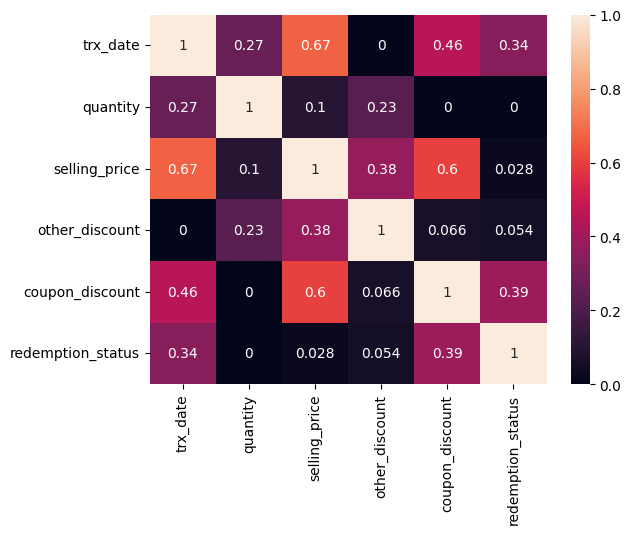

In [ ]:
# Korelasi kolom mengenai transaksi menggunakan Phi K
trx_col = ['trx_date','quantity','selling_price','other_discount','coupon_discount','redemption_status']
sns.heatmap(data=phik_matrix(df[trx_col],interval_cols=[
    'quantity','selling_price','other_discount','coupon_discount']),annot=True)

Dari kolom-kolom mengenai transaksi, hanya kolom tanggal transaksi dan besarnya diskon dari kupon yang digunakan yang cukup berkorelasi dengan penggunaan suatu kupon diskon.

### 4.3.2 Correlation to Item Columns

<Axes: >

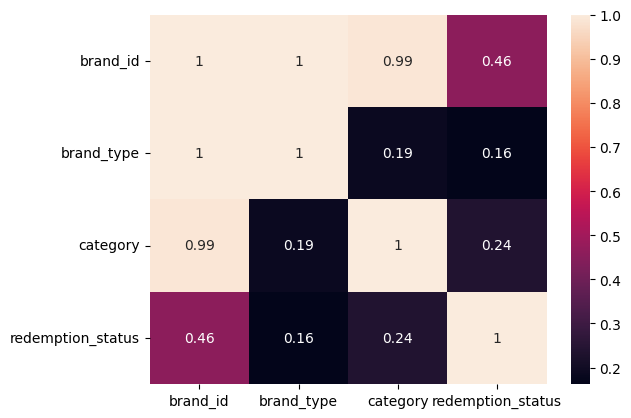

In [ ]:
# Korelasi kolom mengenai barang/item menggunakan Phi K
item_col = ['brand_id', 'brand_type', 'category','redemption_status']
sns.heatmap(data=phik_matrix(df[item_col],interval_cols=[]),annot=True)

Dari kolom mengenai barang yang dijual, semua kolom yaitu brand dari barang tersebut, tipe brand dari barang tersebut, serta kategori barang tersebut berkorelasi dengan penggunaan kupon diskon.

### 4.3.3 Correlation to Campaign Columns

<Axes: >

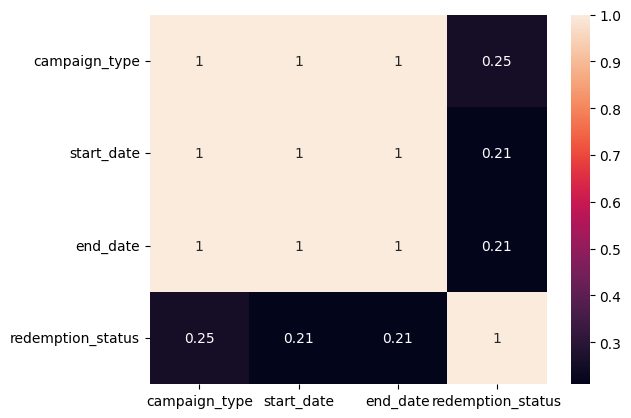

In [ ]:
# Korelasi kolom mengenai campaign/promo menggunakan Phi K
campaign_col = ['campaign_type','start_date','end_date','redemption_status']
sns.heatmap(data=phik_matrix(df[campaign_col],interval_cols=[]),annot=True)

Dari kolom mengenai campaign/promosi dari kupon tersebut, semua kolom yang terdiri dari tipe promosi serta tanggal mulai dan berakhirnya promosi cukup berkorelasi dengan penggunaan suatu kupon diskon.

### 4.3.4 Correlation to Demographics Columns

<Axes: >

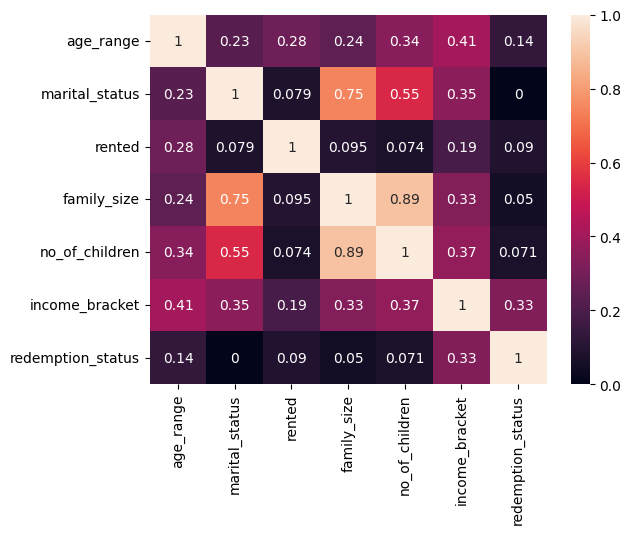

In [ ]:
# Korelasi kolom mengenai demografi pelanggan menggunakan Phi K
demo_col = ['age_range','marital_status','rented','family_size','no_of_children','income_bracket',
            'redemption_status']
sns.heatmap(data=phik_matrix(df[demo_col],interval_cols=[]),annot=True)

Dari kolom mengenai karakteristik atau demografi pelanggan, hanya kelompok umur/age range dan tingkat pendapatan/income bracket yang berkorelasi dengan penggunaan kupon diskon.

### 4.3.5 Correlation to Date Columns

Pada analisa korelasi dengan kolom trx_date, start_date, dan end_date pada bagian sebelumnya, dapat dilihat bahwa kolom-kolom tanggal ini memiliki korelasi yang cukup dengan redemption status. Maka kolom tanggal ini akan dipecah menjadi tahun, bulan, dan tanggal dari masing-masing kolom tanggal untuk mengurangi kardinalitas pada model. Selain itu akan dilihat juga korelasi lamanya promosi yang dilihat dari jarak antara tanggal mulai dan berakhirnya promosi (start_date dan end_date).

In [9]:
# Membuat kolom tahun, bulan dan tanggal dari kolom trx_date
df['trx_year'] = df['trx_date'].dt.year
df['trx_month'] = df['trx_date'].dt.month
df['trx_day'] = df['trx_date'].dt.day

# Membuat kolom tahun, bulan dan tanggal dari kolom start_date
df['start_year'] = df['start_date'].dt.year
df['start_month'] = df['start_date'].dt.month
df['start_day'] = df['start_date'].dt.day

# Membuat kolom tahun, bulan dan tanggal dari kolom end_date
df['end_year'] = df['end_date'].dt.year
df['end_month'] = df['end_date'].dt.month
df['end_day'] = df['end_date'].dt.day

# Membuat kolom lamanya campaign/promosi
df['campaign_length'] = (df['end_date'] - df['start_date']).dt.days

df

,id,campaign_id,coupon_id,customer_id,item_id,redemption_status,trx_date,quantity,selling_price,other_discount,coupon_discount,brand_id,brand_type,category,campaign_type,start_date,end_date,age_range,marital_status,rented,family_size,no_of_children,income_bracket,trx_year,trx_month,trx_day,start_year,start_month,start_day,end_year,end_month,end_day,campaign_length
0,42623,27,1088,195,58195,0,2012-09-10,1,47.73,-16.03,0.00,2088,Established,Pharmaceutical,Y,2012-08-25,2012-10-27,26-35,Married,0,2,0,5,2012,9,10,2012,8,25,2012,10,27,63
1,116763,27,1089,195,58195,0,2012-09-10,1,47.73,-16.03,0.00,2088,Established,Pharmaceutical,Y,2012-08-25,2012-10-27,26-35,Married,0,2,0,5,2012,9,10,2012,8,25,2012,10,27,63
2,27873,3,822,444,13947,0,2012-12-25,1,135.00,-23.87,0.00,57,Established,Grocery,Y,2012-12-22,2013-02-16,46-55,Married,0,2,0,2,2012,12,25,2012,12,22,2013,2,16,56
3,12538,2,1023,619,28100,0,2012-12-25,1,138.56,-92.61,0.00,1587,Established,Grocery,Y,2012-12-17,2013-01-18,36-45,Single,1,2,1,4,2012,12,25,2012,12,17,2013,1,18,32
4,73579,2,1023,823,31672,1,2012-12-27,1,138.56,-92.61,-35.62,1587,Established,Grocery,Y,2012-12-17,2013-01-18,36-45,Married,1,4,2,2,2012,12,27,2012,12,17,2013,1,18,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9323,21683,30,574,590,18311,0,2012-11-30,1,71.24,-35.26,0.00,404,Established,Prepared Food,X,2012-11-19,2013-01-04,36-45,Married,0,2,0,1,2012,11,30,2012,11,19,2013,1,4,46
9324,36691,30,1001,1192,59838,0,2012-12-02,1,71.24,-35.26,0.00,1475,Established,Natural Products,X,2012-11-19,2013-01-04,70+,Single,0,1,0,2,2012,12,2,2012,11,19,2013,1,4,46
9325,95146,30,1004,1192,59838,0,2012-12-02,1,71.24,-35.26,0.00,1475,Established,Natural Products,X,2012-11-19,2013-01-04,70+,Single,0,1,0,2,2012,12,2,2012,11,19,2013,1,4,46
9326,76459,30,1003,460,67131,0,2012-12-13,1,71.24,-35.26,0.00,1475,Established,Natural Products,X,2012-11-19,2013-01-04,70+,Married,0,2,0,5,2012,12,13,2012,11,19,2013,1,4,46


<Axes: >

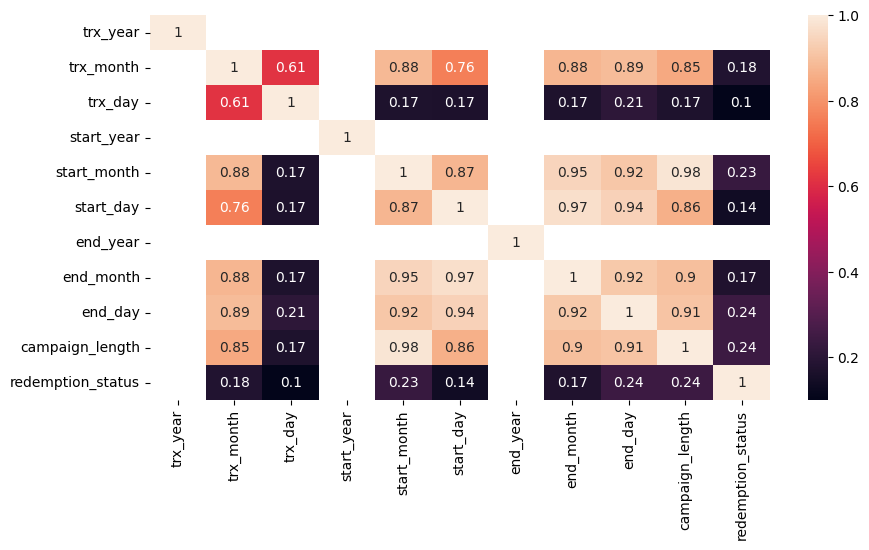

In [ ]:
# Korelasi kolom tanggal menggunakan Phi K
date_col = ['trx_year','trx_month','trx_day','start_year','start_month','start_day','end_year',
            'end_month','end_day','campaign_length','redemption_status']

plt.figure(figsize=(10,5))
sns.heatmap(data=phik_matrix(df[date_col],interval_cols=[
    'trx_year','trx_month','trx_day','start_year','start_month','start_day','end_year','end_month',
    'end_day','campaign_length']),annot=True)

<Axes: >

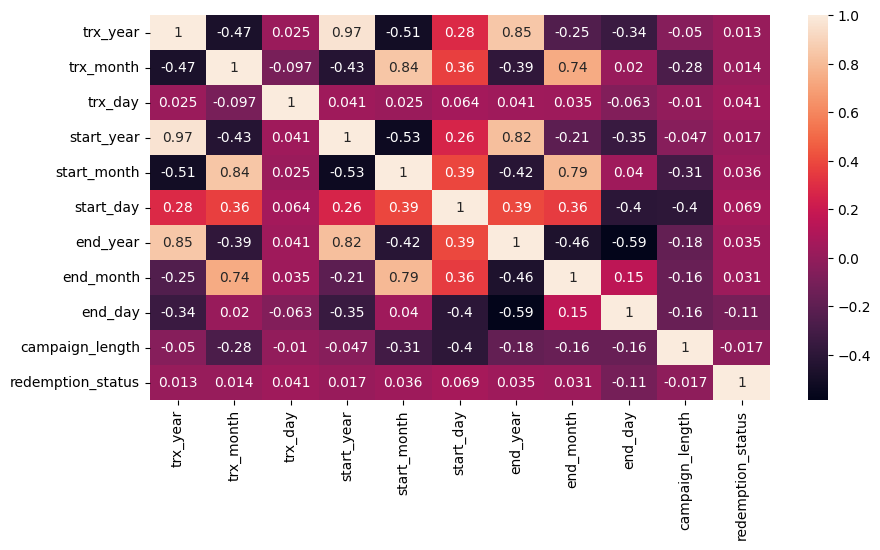

In [ ]:
# Korelasi kolom tanggal menggunakan Kendall
plt.figure(figsize=(10,5))
sns.heatmap(data=df[date_col].corr(method='kendall'),annot=True)

Menurut analisa korelasi menggunakan Phi K, data terkait bulan dan tanggal merupakan data yang berkorelasi dengan penggunaan kupon diskon. Sementara jika menggunakan korelasi Kendall semua data terkait tanggal, bulan, dan tahun tidak cukup berkorelasi dengan penggunaan kupon diskon. Namun biasanya penggunaan diskon dapat tergantung dengan tanggal berlaku promosi tersebut, misalnya diskon pada akhir dan awal bulan yang berdekatan dengan tanggal gajian atau diskon tematik pada saat Natal, Tahun Baru, dll.

Maka sesuai dengan temuan pada heatmap korelasi Phi K, data tanggal dan bulan dari tanggal transaksi, tanggal mulai dan berakhir promosi akan digunakan untuk memprediksi penggunaan kupon diskon.

### 4.3.6 Features to Use Based on Correlation

Dari hasil analisa korelasi kolom-kolom dalam dataset dengan kolom redemption status sebagai target dari project ini, maka didapatkan kolom-kolom berikut yang akan digunakan dalam memprediksi penggunaan kupon diskon. Kolom-kolom ini dikelompokkan kembali ke dalam kolom kontinu, diskrit, dan kolom kategorikal.

In [10]:
# Kolom kontinu
cont_col = ['coupon_discount','campaign_length']

# Kolom diskrit
disc_col = ['trx_month','trx_day','start_month','start_day','end_month','end_day']

# Kolom kategorikal
cat_col = ['brand_id','brand_type','category','campaign_type','age_range','income_bracket']

# Kolom target
target = ['redemption_status']

## 4.4 Continuous Numerical Columns Analysis

### 4.4.1 Descriptive Statistics

In [ ]:
# Informasi mengenai statistik deskriptif dari kolom-kolom kontinu yang ada pada dataset
cont_summary = df[cont_col].describe().loc[['mean','std','min','25%','50%','75%','max']].T

min, max, mean, var, skew, kurt = describe(df[cont_col],axis=0)

mode = []
for column in cont_col:
    x = df[column].mode()[0]
    mode.append(x)

cont_summary['mode'] = mode
cont_summary['var'] = var
cont_summary['skew'] = skew
cont_summary['kurt'] = kurt

cont_summary

,mean,std,min,25%,50%,75%,max,mode,var,skew,kurt
coupon_discount,-2.569479,10.176022,-178.1,0.0,0.0,0.0,0.0,0.0,103.551416,-5.194879,38.490495
campaign_length,45.989280,5.034340,32.0,47.0,47.0,48.0,63.0,47.0,25.344583,-1.671907,3.295371


Dari analisa di atas, sebagian besar pelanggan tidak mendapatkan atau menggunakan diskon karena besaran diskon kupon sebagian besar mendekati 0. Selain itu, kolom diskon kupon memiliki standar deviasi yang cukup besar jika dibandingkan dengan rata-rata datanya, serta distribusi data yang sangat skewed.

Sementara rata-rata lamanya promosi kurang lebih 46 sampai dengan 47 hari dan tidak banyak varians dari data lamanya suatu promosi. Walaupun jarak antara rata-rata data dengan masing-masing titik data cukup kecil, namun distribusi data masih cukup skewed.

### 4.4.2 Outlier Analysis

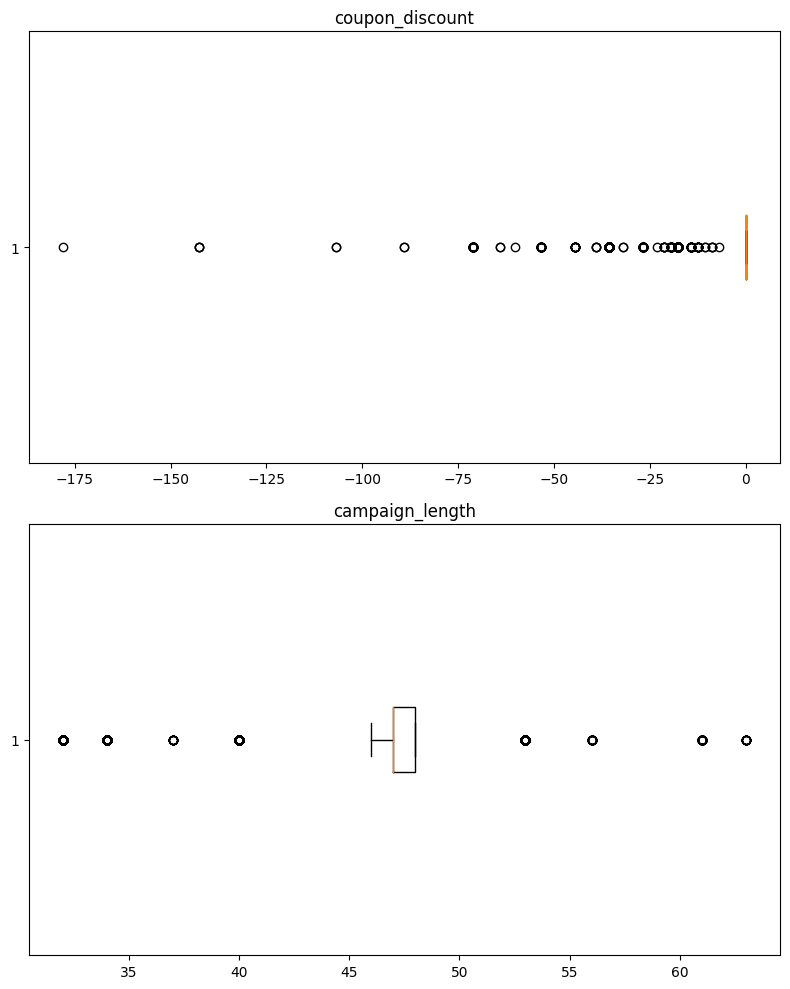

In [ ]:
# Visualisasi outlier pada kolom kontinu dengan box plot

fig, axes = plt.subplots(2, 1, figsize=(8, 10))

for i, column in enumerate(cont_col):
    ax = axes[i]
    ax.boxplot(df[column], vert=False)
    ax.set_title(column)

plt.tight_layout()
plt.show()

Dapat dilihat dari box plot di atas bahwa kedua kolom yang bersifat kontinu memiliki outlier. Terdapat lebih banyak outlier pada kolom besaran diskon dibandingkan dengan data pada kolom lamanya promosi. Hal ini dikarenakan kolom lamanya promosi lebih terdistribusi dengan normal, serta sebagian besar pelanggan tidak menggunakan atau tidak mendapatkan diskon dari kupon sehingga pelanggan yang mendapatkan diskon terutama dengan nominal yang besar akan menjadi outlier.

### 4.4.3 Coupon Discount vs Other Discount

In [134]:
# Membuat tabel persentase diskon antara diskon menggunakan kupon dengan diskon lainnya
disc_perc = pd.DataFrame()
disc_perc['coupon'] = (abs(df['coupon_discount'])/(abs(df['coupon_discount']) + df['selling_price'])) * 100
disc_perc['other'] = (abs(df['other_discount'])/(abs(df['other_discount']) + df['selling_price'])) * 100

disc_perc

,coupon,other
0,0.000000,25.141154
1,0.000000,25.141154
2,0.000000,15.024863
3,0.000000,40.061427
4,20.450109,40.061427
...,...,...
9323,0.000000,33.107981
9324,0.000000,33.107981
9325,0.000000,33.107981
9326,0.000000,33.107981


<Axes: >

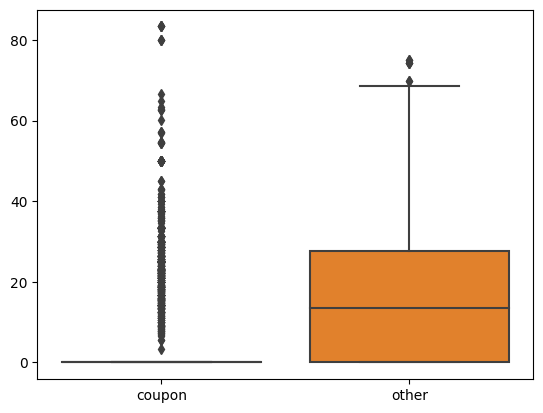

In [141]:
# Menggambarkan perbedaan diskon menggunakan kupon dan diskon lainnya dengan box plot
sns.boxplot(data=disc_perc)

Dilihat dari box plot di atas bahwa diskon dari perusahaan lain lebih besar dan lebih sering digunakan oleh pelanggan dibandingkan dengan besaran kupon diskon yang ditawarkan oleh perusahaan ini.

Namun pada bagian sebelumnya diketahui bahwa diskon lainnya kurang berkorelasi dengan penggunaan kupon diskon yang ditawarkan. Hal ini dapat disebabkan oleh barang yang didiskon merupakan barang yang tidak sensitif terhadap diskon, seperti barang-barang sembako atau grocery yang ada dalam dataset ini. Jenis barang yang berbeda mungkin menyebabkan korelasi diskon yang ditawarkan oleh perusahaan lain terhadap penggunaan kupon diskon yang ditawarkan berubah menjadi lebih berkorelasi.

## 4.5 Discreet Numerical and Categorical Columns Analysis

### 4.5.1 Cardinality Analysis

In [ ]:
# Cek jumlah unique values pada kolom diskrit dan kategorikal untuk menganalisa kardinalitasnya
df[cat_col + disc_col].nunique()

brand_id          545
brand_type          2
category           16
campaign_type       2
age_range           6
income_bracket     12
trx_month          12
trx_day            31
start_month        10
start_day          11
end_month          10
end_day            14
dtype: int64

Dari analisa kardinalitas kolom-kolom kategorikal dan diskrit, didapati kolom brand_id atau brand dari barang yang terjual memiliki unique values yang banyak. Sehingga kolom brand_id tidak dipakai untuk memprediksi penggunaan kupon diskon. Sementara kolom lainnya, walaupun beberapa memiliki unique values yang agak banyak akan tetap digunakan.

### 4.5.2 Coupon Redemption Status by Campaign Type

In [ ]:
# Menghitung persentase penggunaan kupon dari masing-masing campaign type

campaign_redeem = pd.DataFrame()

campaign_0 = df.groupby(df['campaign_type'][df['redemption_status'] == 0]).size().reset_index()
campaign_1 = df.groupby(df['campaign_type'][df['redemption_status'] == 1]).size().reset_index()
campaign_total = df.groupby('campaign_type').size().reset_index()

campaign_redeem['campaign_type'] = campaign_0['campaign_type']
campaign_redeem['perc_0'] = np.round(((campaign_0[0]/campaign_total[0]) * 100),2)
campaign_redeem['perc_1'] = np.round(((campaign_1[0]/campaign_total[0]) * 100),2)

campaign_redeem

,campaign_type,perc_0,perc_1
0,X,72.81,27.19
1,Y,91.81,8.19


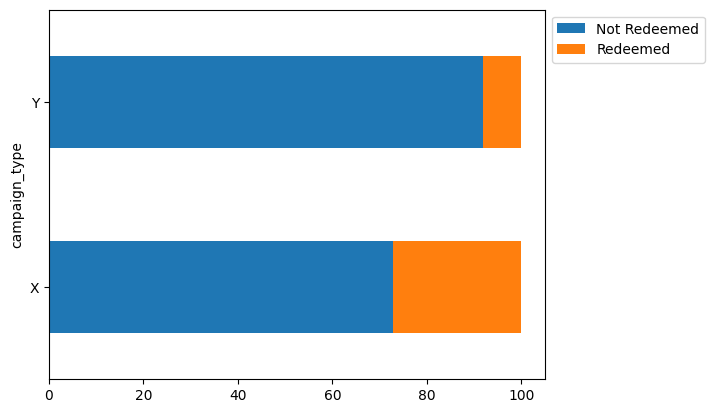

In [142]:
# Menggambarkan stacked bar penggunaan kupon diskon dari setiap tipe campaign
campaign_redeem.plot(x='campaign_type', kind='barh', stacked=True)
plt.legend(['Not Redeemed', 'Redeemed'], bbox_to_anchor=(1, 1))

Dari stacked bar chart di atas, dapat terlihat bahwa tipe campaign/promosi X lebih banyak digunakan oleh pelanggan dibandingkan dengan tipe campaign/promosi Y. Perbedaan ini akan dicek kembali menggunakan t-test.

In [ ]:
# Pengujian t-test dari kolom campaign type
t_stat, p_val = stats.ttest_ind(campaign_0[0],campaign_1[0])

print('t-Statistic:',t_stat)
print('p-value:',p_val)

t-Statistic: 1.0244176436701298
p-value: 0.4133654894650358


Analisis t-test bertujuan untuk mengecek apakah hipotesa yang kita tetapkan diterima atau ditolak. Hipotesa dari pengujian t-test adalah:

H0: Tidak ada perbedaan signifikan antara tipe campaign/promosi

H1: Ada perbedaan yang signifikan antara tipe campaign/promosi

Dari pengecekan t-test di atas, didapatkan p-value lebih dari 0.05 (0.41 > 0.05) sehingga H0 diterima, yang berarti tidak ada campaign type yang berbeda secara signifikan antara satu sama lain.

### 4.5.3 Coupon Redemption Status by Item's Brand and Category

#### 4.5.3.1 Coupon Redemption Status by Brand Type

In [ ]:
# Menghitung persentase penggunaan kupon dari masing-masing brand type

brand_redeem = pd.DataFrame()

brand_0 = df.groupby(df['brand_type'][df['redemption_status'] == 0]).size().reset_index()
brand_1 = df.groupby(df['brand_type'][df['redemption_status'] == 1]).size().reset_index()
brand_total = df.groupby('brand_type').size().reset_index()

brand_redeem['brand_type'] = brand_0['brand_type']
brand_redeem['perc_0'] = np.round(((brand_0[0]/brand_total[0]) * 100),2)
brand_redeem['perc_1'] = np.round(((brand_1[0]/brand_total[0]) * 100),2)

brand_redeem

,brand_type,perc_0,perc_1
0,Established,73.57,26.43
1,Local,84.44,15.56


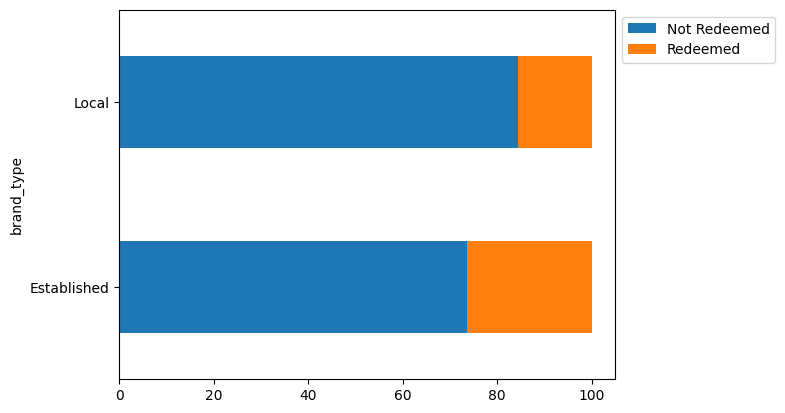

In [143]:
# Menggambarkan stacked bar penggunaan kupon diskon dari setiap tipe brand
brand_redeem.plot(x='brand_type', kind='barh', stacked=True)
plt.legend(['Not Redeemed', 'Redeemed'], bbox_to_anchor=(1, 1))

Dari stacked bar chart di atas, dapat dilihat bahwa diskon pada brand yang tergolong established lebih cenderung digunakan dibandingkan dengan diskon pada brand lokal. Perbedaan ini akan dicek kembali menggunakan t-test.

In [ ]:
# Pengujuan t-test untuk kolom tipe brand
t_stat, p_val = stats.ttest_ind(brand_0[0],brand_1[0])

print('t-Statistic:',t_stat)
print('p-value:',p_val)

t-Statistic: 1.2046335877101204
p-value: 0.3515543989085248


Dari pengecekan t-test di atas, didapatkan p-value lebih dari 0.05 (0.35 > 0.05) sehingga H0 diterima, yang berarti tidak ada tipe brand yang berbeda secara signifikan antara satu sama lain.

#### 4.5.3.2 Coupon Redemption Status by Item's Category

In [19]:
# Menghitung persentase penggunaan kupon dari masing-masing kategori barang

category_summary = df.groupby(['category', 'redemption_status']).size().unstack(fill_value=0)

category_summary['perc_0'] = (category_summary[0] / (category_summary[0] + category_summary[1])) * 100
category_summary['perc_1'] = (category_summary[1] / (category_summary[0] + category_summary[1])) * 100

category_summary = category_summary.reset_index()

category_summary = category_summary.fillna(0)

category_summary = category_summary[['category', 'perc_0', 'perc_1']]

category_summary

redemption_status,category,perc_0,perc_1
0,Bakery,100.000000,0.000000
1,"Dairy, Juices & Snacks",69.421488,30.578512
2,Flowers & Plants,100.000000,0.000000
3,Garden,100.000000,0.000000
4,Grocery,70.926617,29.073383
5,Meat,88.805970,11.194030
6,Miscellaneous,100.000000,0.000000
7,Natural Products,90.608696,9.391304
8,Packaged Meat,84.191617,15.808383
9,Pharmaceutical,89.555556,10.444444


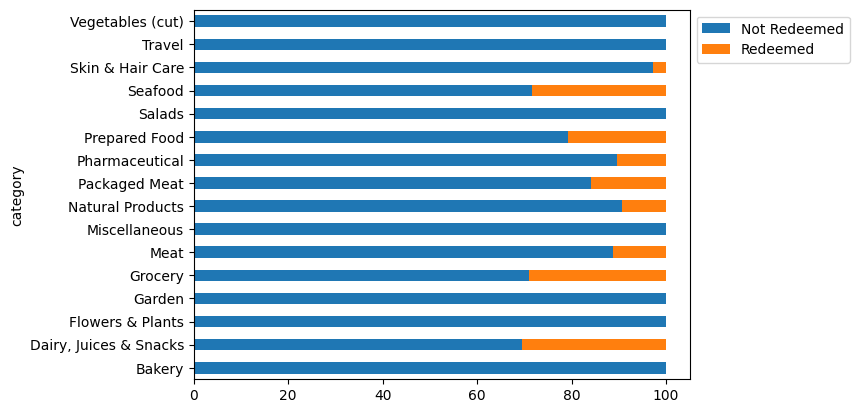

In [20]:
# Menggambarkan stacked bar penggunaan kupon diskon pada setiap kategori barang
category_summary.plot(x='category', kind='barh', stacked=True)
plt.legend(['Not Redeemed', 'Redeemed'], bbox_to_anchor=(1, 1))

Dari bar chart di atas dapat dilihat hampir setengah dari kategori barang dibeli tanpa menggunakan kupon diskon yang ditawarkan. Pelanggan paling banyak menggunakan kupon diskon untuk membeli minuman dan snack, grocery, dan seafood.

Untuk melihat apakah ada perbedaan yang signifikan antara kategori barang, maka akan dilakukan pengujian ANOVA terhadap kolom kategori barang.

In [ ]:
# Pengujian ANOVA pada kolom kategori
cat_redeem = []
for category in df['category'].unique():
    x = df['redemption_status'][df['category']==category]
    cat_redeem.append(x)

f_statistic, p_value = stats.f_oneway(*cat_redeem)
print('p-value:',p_value)

p-value: 4.314065055403438e-63


Untuk menguji ANOVA (Analysis of Variance) dari suatu kelompok, sama dengan uji t-test terdapat hipotesa yang ditetapkan agar dapat dilihat apakah hipotesa tersebut diterima atau ditolak. Hipotesa pengujian ANOVA adalah:

H0: Tidak ada perbedaan signifikan antara kategori barang

H1: Ada perbedaan yang signifikan pada satu atau lebih kategori barang

Dilihat dari pengujian ANOVA di atas, didapatkan p-value yang bernilai kurang dari 0.05 (4.31e-63 < 0.05), sehingga H0 ditolak yang berarti ada perbedaan yang signifikan pada satu atau lebih kategori barang. Hal ini menandakan bahwa kolom kategori barang merupakan kolom ordinal dalam memprediksi penggunaan kupon diskon.

### 4.5.4 Coupon Redemption Status by Customer Characteristics

#### 4.5.4.1 Coupon Redemption Status by Customer's Age

In [22]:
# Menghitung persentase penggunaan kupon dari masing-masing category
age_redeem = pd.DataFrame()

age_0 = df.groupby(df['age_range'][df['redemption_status'] == 0]).size().reset_index()
age_1 = df.groupby(df['age_range'][df['redemption_status'] == 1]).size().reset_index()
age_total = df.groupby('age_range').size().reset_index()

age_redeem['age_range'] = age_0['age_range']
age_redeem['perc_0'] = np.round(((age_0[0]/age_total[0]) * 100),2)
age_redeem['perc_1'] = np.round(((age_1[0]/age_total[0]) * 100),2)

age_redeem

,age_range,perc_0,perc_1
0,18-25,90.14,9.86
1,26-35,78.09,21.91
2,36-45,71.34,28.66
3,46-55,75.41,24.59
4,56-70,80.41,19.59
5,70+,80.66,19.34


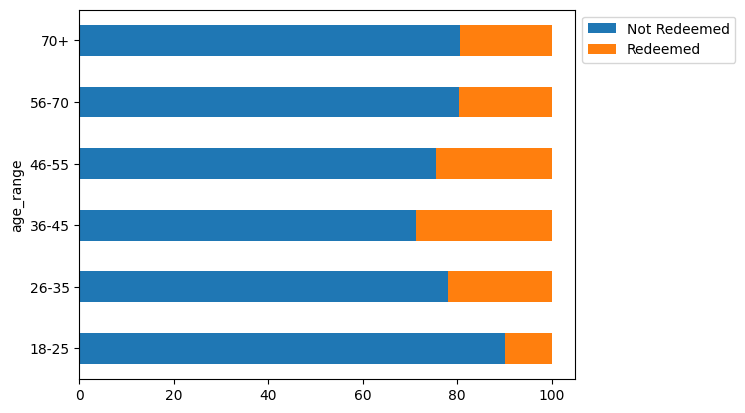

In [23]:
# Menggambarkan stacked bar penggunaan kupon diskon pada setiap kelompok umur
age_redeem.plot(x='age_range', kind='barh', stacked=True)
plt.legend(['Not Redeemed', 'Redeemed'], bbox_to_anchor=(1, 1))

Dari stacked bar chart di atas dapat dilihat adanya perbedaan penggunaan kupon diskon dari setiap kelompok umur, di mana kelompok umur 36 - 55 tahun merupakan dua kelompok umur yang paling banyak menggunakan kupon diskon, dan kelompok umur 18 - 25 merupakan kelompok umur yang paling sedikit menggunakan kupon diskon. Hal ini dapat disebabkan karena barang yang diberikan diskon merupakan barang sembako atau grocery. Apabila ada perbedaan barang yang didiskon mungkin akan ada perbedaan penggunaan kupon diskon oleh tiap-tiap kelompok umur.

Perbedaan penggunaan kupon diskon antar kelompok umur akan dicek kembali signifikansinya menggunakan ANOVA.

In [ ]:
# Pengujian ANOVA pada kolom kelompok umur
age_red = []
for range in df['age_range'].unique():
    x = df['redemption_status'][df['age_range']==range]
    age_red.append(x)

f_statistic, p_value = stats.f_oneway(*age_red)
print('p-value:',p_value)

p-value: 1.2317131471084489e-18


Dilihat dari pengujian ANOVA di atas, didapatkan p-value yang bernilai kurang dari 0.05 (1.23e-18 < 0.05), sehingga H0 ditolak yang berarti ada perbedaan yang signifikan pada satu atau lebih kelompok umur pelanggan. Hal ini menandakan bahwa kolom kelompok umur merupakan kolom ordinal dalam memprediksi penggunaan kupon diskon.

#### 4.5.4.2 Coupon Redemption Status by Customer's Income

In [25]:
# Menghitung persentase penggunaan kupon dari tingkat pendapatan pelanggan

income_summary = df.groupby(['income_bracket', 'redemption_status']).size().unstack(fill_value=0)

income_summary['perc_0'] = (income_summary[0] / (income_summary[0] + income_summary[1])) * 100
income_summary['perc_1'] = (income_summary[1] / (income_summary[0] + income_summary[1])) * 100

income_summary = income_summary.reset_index()

income_summary = income_summary.fillna(0)

income_summary = income_summary[['income_bracket', 'perc_0', 'perc_1']]

income_summary

redemption_status,income_bracket,perc_0,perc_1
0,1,81.969697,18.030303
1,2,78.899083,21.100917
2,3,87.067669,12.932331
3,4,84.447005,15.552995
4,5,61.493625,38.506375
5,6,71.836735,28.163265
6,7,85.956416,14.043584
7,8,89.678511,10.321489
8,9,73.260870,26.739130
9,10,88.679245,11.320755


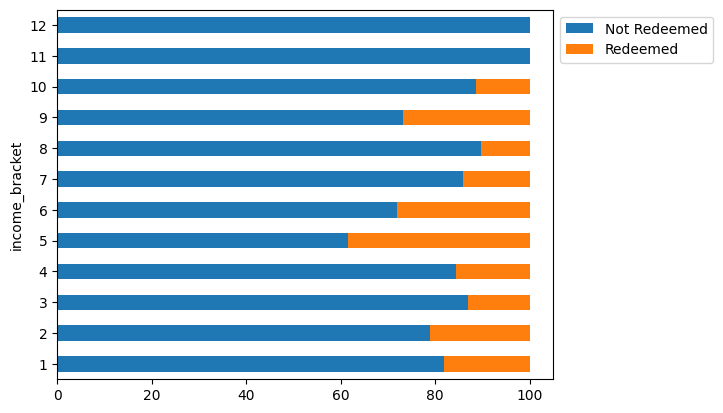

In [26]:
# Menggambarkan stacked bar penggunaan kupon diskon pada setiap tingkat pendapatan
income_summary.plot(x='income_bracket', kind='barh', stacked=True)
plt.legend(['Not Redeemed', 'Redeemed'], bbox_to_anchor=(1, 1))

Dari bar chart di atas dapat dilihat bahwa pelanggan dengan tingkat pendapatan yang tinggi cenderung tidak menggunakan kupon diskon. Penggunaan kupon diskon paling tinggi ada pada pelanggan dengan tingkat pendapatan menengah, seperti pada income bracket 5, 6, dan 9.

Untuk mengetahui apakah ada perbedaan yang signifikan antara tingkat pendapatan pelanggan, maka kolom tingkat pendapatan ini akan diuji menggunakan ANOVA.

In [ ]:
# Pengujian ANOVA pada kolom tingkat pendapatan pelanggan
income_red = []
for bracket in df['income_bracket'].unique():
    x = df['redemption_status'][df['income_bracket']==bracket]
    income_red.append(x)

f_statistic, p_value = stats.f_oneway(*income_red)
print('p-value:',p_value)

p-value: 2.545967399744622e-127


Dilihat dari pengujian ANOVA di atas, didapatkan p-value yang bernilai kurang dari 0.05 (2.55e-127 < 0.05), sehingga H0 ditolak yang berarti ada perbedaan yang signifikan pada satu atau lebih tingkat pendapatan pelanggan.

Hal ini menandakan bahwa kolom kelompok umur merupakan kolom ordinal dalam memprediksi penggunaan kupon diskon. Namun, karena kolom income bracket sudah memiliki data berupa angka atau bertipe integre, maka kolom ini tidak akan di-encode kembali pada bagian feature engineering.

# 5. Feature Engineering

## 5.1 Feature Selection

Untuk memilih fitur yang akan digunakan dalam memprediksi penggunaan kupon diskon, telah dilakukan analisa korelasi pada bagian EDA sebelumnya. Selain itu, fitur akan dipilih menggunakan analisa ANOVA/f-classification untuk menentukan apakah kolom yang sudah dipilih benar-benar berpengaruh terhadap penggunaan kupon diskon.

### 5.1.1 Splitting X and y

X merupakan kolom yang akan digunakan untuk memprediksi penggunaan kupon diskon atau y. X akan diuji kembali apakah benar-benar berbeda atau berpengaruh terhadap penggunaan kupon diskon.

In [ ]:
X = df[['coupon_discount','campaign_length','trx_month','trx_day','start_month','start_day','end_month',
        'end_day','brand_type','category','campaign_type','age_range','income_bracket']]

y = df['redemption_status']

X

,coupon_discount,campaign_length,trx_month,trx_day,start_month,start_day,end_month,end_day,brand_type,category,campaign_type,age_range,income_bracket
0,0.00,63,9,10,8,25,10,27,Established,Pharmaceutical,Y,26-35,5
1,0.00,63,9,10,8,25,10,27,Established,Pharmaceutical,Y,26-35,5
2,0.00,56,12,25,12,22,2,16,Established,Grocery,Y,46-55,2
3,0.00,32,12,25,12,17,1,18,Established,Grocery,Y,36-45,4
4,-35.62,32,12,27,12,17,1,18,Established,Grocery,Y,36-45,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9323,0.00,46,11,30,11,19,1,4,Established,Prepared Food,X,36-45,1
9324,0.00,46,12,2,11,19,1,4,Established,Natural Products,X,70+,2
9325,0.00,46,12,2,11,19,1,4,Established,Natural Products,X,70+,2
9326,0.00,46,12,13,11,19,1,4,Established,Natural Products,X,70+,5


### 5.1.2 Features Transforming

Untuk memilih fitur (feature selection) menggunakan ANOVA/f-classification, terlebih dahulu semua kolom harus berupa numerik. Maka semua kolom kategorikal akan diubah/encode menjadi numerik. Kolom numerik juga akan melalui tahap scaling terlebih dahulu sebelum diuji signifikansinya.

In [11]:
# Kolom nominal
nom_col = ['brand_type','campaign_type']

# Kolom ordinal
ord_col = ['category','age_range']

# Tingakatan kolom kategori barang
category_order = ['Dairy, Juices & Snacks','Grocery','Seafood','Prepared Food','Packaged Meat','Meat',
                'Pharmaceutical','Natural Products','Skin & Hair Care','Flowers & Plants','Garden',
                'Travel','Miscellaneous','Bakery','Vegetables (cut)','Salads']

# Tingkatan kolom kelompok umur
age_order = ['36-45','46-55','26-35','56-70','70+','18-25']

ord_order = [category_order,age_order]

# Kolom numerik
num_col = ['coupon_discount','campaign_length','trx_month','trx_day','start_month','start_day','end_month',
           'end_day']

fclassif_transformer = ColumnTransformer([('numeric',StandardScaler(),num_col),
                                 ('nominal',OneHotEncoder(),nom_col),
                                 ('ordinal',OrdinalEncoder(categories=ord_order),ord_col)
                                ],remainder='passthrough')

fclassif_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric', StandardScaler(),
                                 ['coupon_discount', 'campaign_length',
                                  'trx_month', 'trx_day', 'start_month',
                                  'start_day', 'end_month', 'end_day']),
                                ('nominal', OneHotEncoder(),
                                 ['brand_type', 'campaign_type']),
                                ('ordinal',
                                 OrdinalEncoder(categories=[['Dairy, Juices & '
                                                             'Snacks',
                                                             'Grocery',
                                                             'Seafood',
                                                             'Prepared Food',
                                                             'Packaged Meat',
                                                             'Meat',
                                                             'Pharmaceutical',
                                                             'Natural Products',
                                                             'Skin & Hair Care',
                                                             'Flowers & Plants',
                                                             'Garden', 'Travel',
                                                             'Miscellaneous',
                                                             'Bakery',
                                                             'Vegetables (cut)',
                                                             'Salads'],
                                                            ['36-45', '46-55',
                                                             '26-35', '56-70',
                                                             '70+', '18-25']]),
                                 ['category', 'age_range'])])

### 5.1.3 Features Selection Using ANOVA/F-Classif

In [ ]:
# Transform data untuk melalui proses feature selection
X_fclassif = fclassif_transformer.fit_transform(X)
X_fclassif

array([[2.52516831e-01, 3.37911840e+00, 1.69437187e+00, ...,
        6.00000000e+00, 2.00000000e+00, 5.00000000e+00],
       [2.52516831e-01, 3.37911840e+00, 1.69437187e+00, ...,
        6.00000000e+00, 2.00000000e+00, 5.00000000e+00],
       [2.52516831e-01, 1.98859359e+00, 2.96921666e+00, ...,
        1.00000000e+00, 1.00000000e+00, 2.00000000e+00],
       ...,
       [2.52516831e-01, 2.12957120e-03, 2.96921666e+00, ...,
        7.00000000e+00, 4.00000000e+00, 2.00000000e+00],
       [2.52516831e-01, 2.12957120e-03, 2.96921666e+00, ...,
        7.00000000e+00, 4.00000000e+00, 5.00000000e+00],
       [2.52516831e-01, 2.12957120e-03, 2.96921666e+00, ...,
        7.00000000e+00, 2.00000000e+00, 1.00000000e+00]])

In [ ]:
# Feature selection menggunakan f-classification

F_scores, p_values = f_classif(X_fclassif, y)
fclassif = pd.DataFrame(zip(F_scores,np.round(p_values,5) ),columns=['F_scores', 'p_values'])

fclassif

,F_scores,p_values
0,2045.063855,0.00000
1,16.867606,0.00004
2,0.217727,0.64079
3,22.138234,0.00000
4,0.793868,0.37296
5,92.737468,0.00000
6,0.533195,0.46528
7,103.434842,0.00000
8,103.318803,0.00000
9,103.318803,0.00000


Dari hasil pengujian ANOVA pada tiap kolom X, didapatkan kolom bulan dari tanggal transaksi, tanggal mulai dan berakhirnya promosi (trx_month, start_month, end_month, index=2, 4, 6) tidak signifikan berbeda antara bulan yang ada dalam kolom tersebut. Maka ketiga kolom ini tidak disertakan dalam memprediksi penggunaan kupon diskon.

Sementara kolom tingkat pendapatan pelanggan (income_bracket, index=14) akan tetap dipertahankan walaupun tidak ada perbedaan signifikan di antara tingkat pendapatan pelanggan karena memiliki korelasi yang cukup dengan penggunaan kupon diskon, sudah melalui testing ANOVA pada bagian EDA, serta secara praktis seharusnya tingkat pendapatan seseorang memengaruhi pola konsumsinya.

### 5.1.4 Finalizing X and y

Dari hasil feature selection menggunakan f-classification, didapatkan kolom X berikut yang akan digunakan untuk memprediksi penggunaan kupon diskon atau y.

In [12]:
X_new = df[['coupon_discount','campaign_length','trx_day','start_day','end_day','brand_type','category',
        'campaign_type','age_range','income_bracket']]

y_new = df['redemption_status']

X_new

,coupon_discount,campaign_length,trx_day,start_day,end_day,brand_type,category,campaign_type,age_range,income_bracket
0,0.00,63,10,25,27,Established,Pharmaceutical,Y,26-35,5
1,0.00,63,10,25,27,Established,Pharmaceutical,Y,26-35,5
2,0.00,56,25,22,16,Established,Grocery,Y,46-55,2
3,0.00,32,25,17,18,Established,Grocery,Y,36-45,4
4,-35.62,32,27,17,18,Established,Grocery,Y,36-45,2
...,...,...,...,...,...,...,...,...,...,...
9323,0.00,46,30,19,4,Established,Prepared Food,X,36-45,1
9324,0.00,46,2,19,4,Established,Natural Products,X,70+,2
9325,0.00,46,2,19,4,Established,Natural Products,X,70+,2
9326,0.00,46,13,19,4,Established,Natural Products,X,70+,5


## 5.2 Oversampling Using SMOTE-NC

In [ ]:
# Cek data imbalance
df['redemption_status'].value_counts()

0    7090
1    2897
Name: redemption_status, dtype: int64

Dari hasil pengecekan data imbalance di atas, didapati adanya imbalance pada data penggunaan kupon. Walaupun imbalance pada data y ini tidak terlalu besar, di mana pelanggan yang menggunakan kupon ada 29% dari keseluruhan data, namun agar model prediksi dapat mempelajari lebih baik maka akan dilakukan oversampling menggunakan SMOTE-NC.

In [13]:
# Oversampling menggunakan SMOTE-NC

smotenc = SMOTENC(categorical_features=[5,6,7,8],
                  sampling_strategy='minority',
                  n_jobs=-1)

X_balanced, y_balanced = smotenc.fit_resample(X_new, y_new)
y_balanced.value_counts()

0    7082
1    7082
Name: redemption_status, dtype: int64

## 5.3 Split Train Set and Test Set

In [14]:
# Split train and test

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size = 0.2,
                                                    stratify=y_balanced, random_state = 96)

print('X-train', X_train.shape)
print('X-Test', X_test.shape)

X-train (11331, 10)
X-Test (2833, 10)


## 5.4 Outlier Handling

Karena adanya outlier pada kolom numerik, maka outlier pada kolom numerik tersebut akan diatasi menggunakan metode capping. Metode capping digunakan agar tidak ada informasi yang hilang dari dataset.

In [15]:
# Handling outlier dengan menggunakan Winsorizer

cap = Winsorizer(capping_method='iqr', tail='both', fold=1.5, variables='campaign_length')

Capping hanya akan dilakukan pada kolom campaign length atau lamanya periode promosi karena kolom coupon discount atau besarnya diskon bernilai terlalu kecil untuk dilakukan capping menggunakan Winsorizer. Hal ini terjadi karena value pada kolom coupon discount bernilai negatif.

## 5.5 Features Transforming

Untuk scaling kolom numerik dan encoding kolom kategorikal, dapat digunakan Column Transformer untuk mempermudah pengubahan data.

Pada bagian feature transformation ini akan dibuat dua column transformer, di mana satu transformer digunakan untuk model KNN, SVM, dan boosting menggunakan AdaBoost, di mana column transformer ini akan melakukan scaling pada kolom numerikal. Sementara satu transformer lainnya akan digunakan pada model Decision Tree dan Random Forest, di mana column transformer ini tidak akan melakukan scaling pada kolom numerikal. Scaling tidak harus dilakukan pada model yang berbasis tree seperti Decision Tree dan Random Forest karena model berbasis tree tidak peduli terhadap kardinalitas data.

In [38]:
# Kolom numerik setelah Feature Selection
num_col = ['coupon_discount','campaign_length','trx_day','start_day','end_day']

# Column Transformer untuk KNN, SVM, dan AdaBoost
transformer = ColumnTransformer([('numeric',StandardScaler(),num_col),
                                 ('nominal',OneHotEncoder(),nom_col),
                                 ('ordinal',OrdinalEncoder(categories=ord_order),ord_col)
                                ],remainder='passthrough')

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric', StandardScaler(),
                                 ['coupon_discount', 'campaign_length',
                                  'trx_day', 'start_day', 'end_day']),
                                ('nominal', OneHotEncoder(),
                                 ['brand_type', 'campaign_type']),
                                ('ordinal',
                                 OrdinalEncoder(categories=[['Dairy, Juices & '
                                                             'Snacks',
                                                             'Grocery',
                                                             'Seafood',
                                                             'Prepared Food',
                                                             'Packaged Meat',
                                                             'Meat',
                                                             'Pharmaceutical',
                                                             'Natural Products',
                                                             'Skin & Hair Care',
                                                             'Flowers & Plants',
                                                             'Garden', 'Travel',
                                                             'Miscellaneous',
                                                             'Bakery',
                                                             'Vegetables (cut)',
                                                             'Salads'],
                                                            ['36-45', '46-55',
                                                             '26-35', '56-70',
                                                             '70+', '18-25']]),
                                 ['category', 'age_range'])])

In [16]:
# Column Transformer untuk Decision Tree dan Random Forest
tree_encoder = ColumnTransformer([('nominal',OneHotEncoder(),nom_col),
                                 ('ordinal',OrdinalEncoder(categories=ord_order),ord_col)
                                ],remainder='passthrough')
tree_encoder

ColumnTransformer(remainder='passthrough',
                  transformers=[('nominal', OneHotEncoder(),
                                 ['brand_type', 'campaign_type']),
                                ('ordinal',
                                 OrdinalEncoder(categories=[['Dairy, Juices & '
                                                             'Snacks',
                                                             'Grocery',
                                                             'Seafood',
                                                             'Prepared Food',
                                                             'Packaged Meat',
                                                             'Meat',
                                                             'Pharmaceutical',
                                                             'Natural Products',
                                                             'Skin & Hair Care',
                                                             'Flowers & Plants',
                                                             'Garden', 'Travel',
                                                             'Miscellaneous',
                                                             'Bakery',
                                                             'Vegetables (cut)',
                                                             'Salads'],
                                                            ['36-45', '46-55',
                                                             '26-35', '56-70',
                                                             '70+', '18-25']]),
                                 ['category', 'age_range'])])

## 5.6 PCA

PCA digunakan untuk mengurangi multicollinearity pada data serta mengurangi dimensi data agar model dapat mempelajari data dengan baik. Namun, PCA hanya akan diterapkan pada Pipeline KNN, SVM, dan AdaBoost karena model berbasis tree seperti Decision Tree dan Random Forest tidak terpengaruh dengan multicollinearity.

In [40]:
# PCA dengan 95% informasi dataset dipertahankan
pca = PCA(n_components=0.95)
pca

PCA(n_components=0.95)

## 5.7 Finalizing Feature Engineering Pipeline

Untuk menyesuaikan data agar dapat dipelajari oleh masing-masing model, maka akan digunakan dua pipeline, di mana satu pipeline digunakan untuk model KNN, SVM, dan AdaBoost, sementara pipeline lainnya akan digunakan pada model Decision Tree dan Random Forest.

In [ ]:
# Pipeline Feature Engineering KNN, SVM, AdaBoost
preprocessing = Pipeline([('capping',cap),
                          ('transform', transformer),
                          ('pca',pca)])
preprocessing

Pipeline(steps=[('capping',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables='campaign_length')),
                ('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric', StandardScaler(),
                                                  ['coupon_discount',
                                                   'campaign_length', 'trx_day',
                                                   'start_day', 'end_day']),
                                                 ('nominal', OneHotEncoder(),
                                                  ['brand_type',
                                                   'campaign_type']),
                                                 ('ordinal',
                                                  Or...iry, '
                                                                              'Juices '
                                                                              '& '
                                                                              'Snacks',
                                                                              'Grocery',
                                                                              'Seafood',
                                                                              'Prepared '
                                                                              'Food',
                                                                              'Packaged '
                                                                              'Meat',
                                                                              'Meat',
                                                                              'Pharmaceutical',
                                                                              'Natural '
                                                                              'Products',
                                                                              'Skin '
                                                                              '& '
                                                                              'Hair '
                                                                              'Care',
                                                                              'Flowers '
                                                                              '& '
                                                                              'Plants',
                                                                              'Garden',
                                                                              'Travel',
                                                                              'Miscellaneous',
                                                                              'Bakery',
                                                                              'Vegetables '
                                                                              '(cut)',
                                                                              'Salads'],
                                                                             ['36-45',
                                                                              '46-55',
                                                                              '26-35',
                                                                              '56-70',
                                                                              '70+',
                                                                              '18-25']]),
                                                  ['category', 'age_range'])])),
                ('pca', PCA(n_components=0.95))])

In [17]:
# Pipeline Feature Enginering Decision Tree dan Random Forest
tree_preprocessing = Pipeline([('capping',cap),
                               ('encoder', tree_encoder)])
tree_preprocessing

Pipeline(steps=[('capping',
                 Winsorizer(capping_method='iqr', fold=1.5, tail='both',
                            variables='campaign_length')),
                ('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('nominal', OneHotEncoder(),
                                                  ['brand_type',
                                                   'campaign_type']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['Dairy, '
                                                                              'Juices '
                                                                              '& '
                                                                              'Snacks',
                                                                              'Grocery',
                                                                              'Seafood',
                                                                              'Prepared '
                                                                              'Food',
                                                                              'Packaged '
                                                                              'Meat',
                                                                              'Meat',
                                                                              'Pharmaceutical',
                                                                              'Natural '
                                                                              'Products',
                                                                              'Skin '
                                                                              '& '
                                                                              'Hair '
                                                                              'Care',
                                                                              'Flowers '
                                                                              '& '
                                                                              'Plants',
                                                                              'Garden',
                                                                              'Travel',
                                                                              'Miscellaneous',
                                                                              'Bakery',
                                                                              'Vegetables '
                                                                              '(cut)',
                                                                              'Salads'],
                                                                             ['36-45',
                                                                              '46-55',
                                                                              '26-35',
                                                                              '56-70',
                                                                              '70+',
                                                                              '18-25']]),
                                                  ['category',
                                                   'age_range'])]))])

# 6. Model Definition

Dalam project ini akan digunakan 5 baseline model, yaitu KNN, SVM, Decision Tree, Random Forest, dan AdaBoost sebagai salah satu model boosting. Kelima model ini akan dievaluasi dan digunakan model yang terbaik.

In [ ]:
# Pipeline KNN
knn_pipe = Pipeline([('pre-processing', preprocessing), ('knn', KNeighborsClassifier(n_jobs=-1))])
knn_pipe

Pipeline(steps=[('pre-processing',
                 Pipeline(steps=[('capping',
                                  Winsorizer(capping_method='iqr', fold=1.5,
                                             tail='both',
                                             variables='campaign_length')),
                                 ('transform',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('numeric',
                                                                   StandardScaler(),
                                                                   ['coupon_discount',
                                                                    'campaign_length',
                                                                    'trx_day',
                                                                    'start_day',
                                                                    'end_day']),
                                                                  ('nominal',
                                                                   OneHotEncoder(),
                                                                   ['brand_typ...
                                                                                               'Seafood',
                                                                                               'Prepared '
                                                                                               'Food',
                                                                                               'Packaged '
                                                                                               'Meat',
                                                                                               'Meat',
                                                                                               'Pharmaceutical',
                                                                                               'Natural '
                                                                                               'Products',
                                                                                               'Skin '
                                                                                               '& '
                                                                                               'Hair '
                                                                                               'Care',
                                                                                               'Flowers '
                                                                                               '& '
                                                                                               'Plants',
                                                                                               'Garden',
                                                                                               'Travel',
                                                                                               'Miscellaneous',
                                                                                               'Bakery',
                                                                                               'Vegetables '
                                                                                               '(cut)',
                                                                                               'Salads'],
                                                                                              ['36-45',
                                                                                               '46-55',
                                                                                               '26-35',
                              

In [ ]:
# Pipeline SVM
svm_pipe = Pipeline([('pre-processing', preprocessing), ('svm', SVC())])
svm_pipe

Pipeline(steps=[('pre-processing',
                 Pipeline(steps=[('capping',
                                  Winsorizer(capping_method='iqr', fold=1.5,
                                             tail='both',
                                             variables='campaign_length')),
                                 ('transform',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('numeric',
                                                                   StandardScaler(),
                                                                   ['coupon_discount',
                                                                    'campaign_length',
                                                                    'trx_day',
                                                                    'start_day',
                                                                    'end_day']),
                                                                  ('nominal',
                                                                   OneHotEncoder(),
                                                                   ['brand_typ...
                                                                                               'Snacks',
                                                                                               'Grocery',
                                                                                               'Seafood',
                                                                                               'Prepared '
                                                                                               'Food',
                                                                                               'Packaged '
                                                                                               'Meat',
                                                                                               'Meat',
                                                                                               'Pharmaceutical',
                                                                                               'Natural '
                                                                                               'Products',
                                                                                               'Skin '
                                                                                               '& '
                                                                                               'Hair '
                                                                                               'Care',
                                                                                               'Flowers '
                                                                                               '& '
                                                                                               'Plants',
                                                                                               'Garden',
                                                                                               'Travel',
                                                                                               'Miscellaneous',
                                                                                               'Bakery',
                                                                                               'Vegetables '
                                                                                               '(cut)',
                                                                                               'Salads'],
                                                                                              ['36-45',
                           

In [ ]:
# Pipeline Decision Tree
dt_pipe = Pipeline([('pre-processing',tree_preprocessing),('decision_tree', DecisionTreeClassifier())])
dt_pipe

Pipeline(steps=[('pre-processing',
                 Pipeline(steps=[('capping',
                                  Winsorizer(capping_method='iqr', fold=1.5,
                                             tail='both',
                                             variables='campaign_length')),
                                 ('encoder',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('nominal',
                                                                   OneHotEncoder(),
                                                                   ['brand_type',
                                                                    'campaign_type']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Dairy, '
                                                                                               'Juices '
                                                                                               '& '
                                                                                               'Snacks',
                                                                                               'Grocery',
                                                                                               'Seafood',
                                                                                               'Prepared '
                                                                                               'Food',
                                                                                               'Packaged '
                                                                                               'Meat',
                                                                                               'Meat',
                                                                                               'Pharmaceutical',
                                                                                               'Natural '
                                                                                               'Products',
                                                                                               'Skin '
                                                                                               '& '
                                                                                               'Hair '
                                                                                               'Care',
                                                                                               'Flowers '
                                                                                               '& '
                                                                                               'Plants',
                                                                                               'Garden',
                                                                                               'Travel',
                                                                                               'Miscellaneous',
                                                                                               'Bakery',
                                                                                               'Vegetables '
                                                                                               '(cut)',
                                                                                               'Salads'],
                                                                                              ['36-45',
                                                                                               '46-55',
                            

In [18]:
# Pipeline Random Forest
rf_pipe = Pipeline([('pre-processing',tree_preprocessing),('random_forest',
                                                           RandomForestClassifier(n_jobs=-1))])
rf_pipe

Pipeline(steps=[('pre-processing',
                 Pipeline(steps=[('capping',
                                  Winsorizer(capping_method='iqr', fold=1.5,
                                             tail='both',
                                             variables='campaign_length')),
                                 ('encoder',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('nominal',
                                                                   OneHotEncoder(),
                                                                   ['brand_type',
                                                                    'campaign_type']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Dairy, '
                                                                                               'Juices '
                                                                                               '& '
                                                                                               'Snacks',
                                                                                               'Grocery',
                                                                                               'Seafood',
                                                                                               'Prepared '
                                                                                               'Food',
                                                                                               'Packaged '
                                                                                               'Meat',
                                                                                               'Meat',
                                                                                               'Pharmaceutical',
                                                                                               'Natural '
                                                                                               'Products',
                                                                                               'Skin '
                                                                                               '& '
                                                                                               'Hair '
                                                                                               'Care',
                                                                                               'Flowers '
                                                                                               '& '
                                                                                               'Plants',
                                                                                               'Garden',
                                                                                               'Travel',
                                                                                               'Miscellaneous',
                                                                                               'Bakery',
                                                                                               'Vegetables '
                                                                                               '(cut)',
                                                                                               'Salads'],
                                                                                              ['36-45',
                                                                                               '46-55',
                            

In [ ]:
# Pipeline AdaBoost
boosting_pipe = Pipeline([('pre-processing', preprocessing), ('ada_boost', AdaBoostClassifier())])

boosting_pipe

Pipeline(steps=[('pre-processing',
                 Pipeline(steps=[('capping',
                                  Winsorizer(capping_method='iqr', fold=1.5,
                                             tail='both',
                                             variables='campaign_length')),
                                 ('transform',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('numeric',
                                                                   StandardScaler(),
                                                                   ['coupon_discount',
                                                                    'campaign_length',
                                                                    'trx_day',
                                                                    'start_day',
                                                                    'end_day']),
                                                                  ('nominal',
                                                                   OneHotEncoder(),
                                                                   ['brand_typ...
                                                                                               'Seafood',
                                                                                               'Prepared '
                                                                                               'Food',
                                                                                               'Packaged '
                                                                                               'Meat',
                                                                                               'Meat',
                                                                                               'Pharmaceutical',
                                                                                               'Natural '
                                                                                               'Products',
                                                                                               'Skin '
                                                                                               '& '
                                                                                               'Hair '
                                                                                               'Care',
                                                                                               'Flowers '
                                                                                               '& '
                                                                                               'Plants',
                                                                                               'Garden',
                                                                                               'Travel',
                                                                                               'Miscellaneous',
                                                                                               'Bakery',
                                                                                               'Vegetables '
                                                                                               '(cut)',
                                                                                               'Salads'],
                                                                                              ['36-45',
                                                                                               '46-55',
                                                                                               '26-35',
                              

# 7. Model Training

In [ ]:
# Training KNN
knn_pipe.fit(X_train,y_train)

Pipeline(steps=[('pre-processing',
                 Pipeline(steps=[('capping',
                                  Winsorizer(capping_method='iqr', fold=1.5,
                                             tail='both',
                                             variables='campaign_length')),
                                 ('transform',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('numeric',
                                                                   StandardScaler(),
                                                                   ['coupon_discount',
                                                                    'campaign_length',
                                                                    'trx_day',
                                                                    'start_day',
                                                                    'end_day']),
                                                                  ('nominal',
                                                                   OneHotEncoder(),
                                                                   ['brand_typ...
                                                                                               'Seafood',
                                                                                               'Prepared '
                                                                                               'Food',
                                                                                               'Packaged '
                                                                                               'Meat',
                                                                                               'Meat',
                                                                                               'Pharmaceutical',
                                                                                               'Natural '
                                                                                               'Products',
                                                                                               'Skin '
                                                                                               '& '
                                                                                               'Hair '
                                                                                               'Care',
                                                                                               'Flowers '
                                                                                               '& '
                                                                                               'Plants',
                                                                                               'Garden',
                                                                                               'Travel',
                                                                                               'Miscellaneous',
                                                                                               'Bakery',
                                                                                               'Vegetables '
                                                                                               '(cut)',
                                                                                               'Salads'],
                                                                                              ['36-45',
                                                                                               '46-55',
                                                                                               '26-35',
                              

In [ ]:
# Training SVM
svm_pipe.fit(X_train,y_train)

Pipeline(steps=[('pre-processing',
                 Pipeline(steps=[('capping',
                                  Winsorizer(capping_method='iqr', fold=1.5,
                                             tail='both',
                                             variables='campaign_length')),
                                 ('transform',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('numeric',
                                                                   StandardScaler(),
                                                                   ['coupon_discount',
                                                                    'campaign_length',
                                                                    'trx_day',
                                                                    'start_day',
                                                                    'end_day']),
                                                                  ('nominal',
                                                                   OneHotEncoder(),
                                                                   ['brand_typ...
                                                                                               'Snacks',
                                                                                               'Grocery',
                                                                                               'Seafood',
                                                                                               'Prepared '
                                                                                               'Food',
                                                                                               'Packaged '
                                                                                               'Meat',
                                                                                               'Meat',
                                                                                               'Pharmaceutical',
                                                                                               'Natural '
                                                                                               'Products',
                                                                                               'Skin '
                                                                                               '& '
                                                                                               'Hair '
                                                                                               'Care',
                                                                                               'Flowers '
                                                                                               '& '
                                                                                               'Plants',
                                                                                               'Garden',
                                                                                               'Travel',
                                                                                               'Miscellaneous',
                                                                                               'Bakery',
                                                                                               'Vegetables '
                                                                                               '(cut)',
                                                                                               'Salads'],
                                                                                              ['36-45',
                           

In [ ]:
# Training Decision Tree
dt_pipe.fit(X_train,y_train)

Pipeline(steps=[('pre-processing',
                 Pipeline(steps=[('capping',
                                  Winsorizer(capping_method='iqr', fold=1.5,
                                             tail='both',
                                             variables='campaign_length')),
                                 ('encoder',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('nominal',
                                                                   OneHotEncoder(),
                                                                   ['brand_type',
                                                                    'campaign_type']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Dairy, '
                                                                                               'Juices '
                                                                                               '& '
                                                                                               'Snacks',
                                                                                               'Grocery',
                                                                                               'Seafood',
                                                                                               'Prepared '
                                                                                               'Food',
                                                                                               'Packaged '
                                                                                               'Meat',
                                                                                               'Meat',
                                                                                               'Pharmaceutical',
                                                                                               'Natural '
                                                                                               'Products',
                                                                                               'Skin '
                                                                                               '& '
                                                                                               'Hair '
                                                                                               'Care',
                                                                                               'Flowers '
                                                                                               '& '
                                                                                               'Plants',
                                                                                               'Garden',
                                                                                               'Travel',
                                                                                               'Miscellaneous',
                                                                                               'Bakery',
                                                                                               'Vegetables '
                                                                                               '(cut)',
                                                                                               'Salads'],
                                                                                              ['36-45',
                                                                                               '46-55',
                            

In [20]:
# Training Random Forest
rf_pipe.fit(X_train,y_train)

Pipeline(steps=[('pre-processing',
                 Pipeline(steps=[('capping',
                                  Winsorizer(capping_method='iqr', fold=1.5,
                                             tail='both',
                                             variables='campaign_length')),
                                 ('encoder',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('nominal',
                                                                   OneHotEncoder(),
                                                                   ['brand_type',
                                                                    'campaign_type']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Dairy, '
                                                                                               'Juices '
                                                                                               '& '
                                                                                               'Snacks',
                                                                                               'Grocery',
                                                                                               'Seafood',
                                                                                               'Prepared '
                                                                                               'Food',
                                                                                               'Packaged '
                                                                                               'Meat',
                                                                                               'Meat',
                                                                                               'Pharmaceutical',
                                                                                               'Natural '
                                                                                               'Products',
                                                                                               'Skin '
                                                                                               '& '
                                                                                               'Hair '
                                                                                               'Care',
                                                                                               'Flowers '
                                                                                               '& '
                                                                                               'Plants',
                                                                                               'Garden',
                                                                                               'Travel',
                                                                                               'Miscellaneous',
                                                                                               'Bakery',
                                                                                               'Vegetables '
                                                                                               '(cut)',
                                                                                               'Salads'],
                                                                                              ['36-45',
                                                                                               '46-55',
                            

In [ ]:
# Training AdaBoost
boosting_pipe.fit(X_train,y_train)

Pipeline(steps=[('pre-processing',
                 Pipeline(steps=[('capping',
                                  Winsorizer(capping_method='iqr', fold=1.5,
                                             tail='both',
                                             variables='campaign_length')),
                                 ('transform',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('numeric',
                                                                   StandardScaler(),
                                                                   ['coupon_discount',
                                                                    'campaign_length',
                                                                    'trx_day',
                                                                    'start_day',
                                                                    'end_day']),
                                                                  ('nominal',
                                                                   OneHotEncoder(),
                                                                   ['brand_typ...
                                                                                               'Seafood',
                                                                                               'Prepared '
                                                                                               'Food',
                                                                                               'Packaged '
                                                                                               'Meat',
                                                                                               'Meat',
                                                                                               'Pharmaceutical',
                                                                                               'Natural '
                                                                                               'Products',
                                                                                               'Skin '
                                                                                               '& '
                                                                                               'Hair '
                                                                                               'Care',
                                                                                               'Flowers '
                                                                                               '& '
                                                                                               'Plants',
                                                                                               'Garden',
                                                                                               'Travel',
                                                                                               'Miscellaneous',
                                                                                               'Bakery',
                                                                                               'Vegetables '
                                                                                               '(cut)',
                                                                                               'Salads'],
                                                                                              ['36-45',
                                                                                               '46-55',
                                                                                               '26-35',
                              

# 8. Model Evaluation

## 8.1 Cross Validating All Models

In [ ]:
# Cross Validation KNN

knn_cross_val = cross_val_score(estimator=knn_pipe,
                                  X=X_train,
                                  y=y_train,
                                  scoring='f1',
                                  cv=5,
                                  n_jobs=-1,
                                  verbose=0)

print('F1 Score - All - Cross Validation  : ', knn_cross_val)
print('F1 Score - Mean - Cross Validation : ', knn_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', knn_cross_val.std())
print('F1 Score - Range of Train-Set      : ', (knn_cross_val.mean()-knn_cross_val.std()) , '-', (knn_cross_val.mean()+knn_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.88260497 0.88577495 0.87521664 0.86604096 0.87832534]
F1 Score - Mean - Cross Validation :  0.8775925696656428
F1 Score - Std - Cross Validation  :  0.006807308473658652
F1 Score - Range of Train-Set      :  0.8707852611919842 - 0.8843998781393014


In [ ]:
# Cross Validation SVM

svm_cross_val = cross_val_score(estimator=svm_pipe,
                                  X=X_train,
                                  y=y_train,
                                  scoring='f1',
                                  cv=5,
                                  n_jobs=-1,
                                  verbose=0)

print('F1 Score - All - Cross Validation  : ', svm_cross_val)
print('F1 Score - Mean - Cross Validation : ', svm_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', svm_cross_val.std())
print('F1 Score - Range of Train-Set      : ', (svm_cross_val.mean()-svm_cross_val.std()) , '-', (svm_cross_val.mean()+svm_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.80168067 0.7873633  0.78726968 0.81170169 0.7703827 ]
F1 Score - Mean - Cross Validation :  0.7916796087657204
F1 Score - Std - Cross Validation  :  0.014089296861738244
F1 Score - Range of Train-Set      :  0.7775903119039822 - 0.8057689056274586


In [ ]:
# Cross Validation Decision Tree

dt_cross_val = cross_val_score(estimator=dt_pipe,
                                  X=X_train,
                                  y=y_train,
                                  scoring='f1',
                                  cv=5,
                                  n_jobs=-1,
                                  verbose=0)

print('F1 Score - All - Cross Validation  : ', dt_cross_val)
print('F1 Score - Mean - Cross Validation : ', dt_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', dt_cross_val.std())
print('F1 Score - Range of Train-Set      : ', (dt_cross_val.mean()-dt_cross_val.std()) , '-', (dt_cross_val.mean()+dt_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.89208007 0.8990116  0.88898526 0.89734816 0.90047805]
F1 Score - Mean - Cross Validation :  0.8955806284487826
F1 Score - Std - Cross Validation  :  0.004350479874530341
F1 Score - Range of Train-Set      :  0.8912301485742523 - 0.8999311083233129


In [ ]:
# Cross Validarion Random Forest

rf_cross_val = cross_val_score(estimator=rf_pipe,
                                  X=X_train,
                                  y=y_train,
                                  scoring='f1',
                                  cv=5,
                                  n_jobs=-1,
                                  verbose=0)

print('F1 Score - All - Cross Validation  : ', rf_cross_val)
print('F1 Score - Mean - Cross Validation : ', rf_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', rf_cross_val.std())
print('F1 Score - Range of Train-Set      : ', (rf_cross_val.mean()-rf_cross_val.std()) , '-', (rf_cross_val.mean()+rf_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.90539957 0.90519091 0.90601992 0.90098586 0.90482399]
F1 Score - Mean - Cross Validation :  0.90448404799231
F1 Score - Std - Cross Validation  :  0.0017916275719575836
F1 Score - Range of Train-Set      :  0.9026924204203524 - 0.9062756755642676


In [ ]:
# Cross Validation AdaBoost

ada_cross_val = cross_val_score(estimator=boosting_pipe,
                                  X=X_train,
                                  y=y_train,
                                  scoring='f1',
                                  cv=5,
                                  n_jobs=-1,
                                  verbose=0)

print('F1 Score - All - Cross Validation  : ', ada_cross_val)
print('F1 Score - Mean - Cross Validation : ', ada_cross_val.mean())
print('F1 Score - Std - Cross Validation  : ', ada_cross_val.std())
print('F1 Score - Range of Train-Set      : ', (ada_cross_val.mean()-ada_cross_val.std()) , '-', (ada_cross_val.mean()+ada_cross_val.std()))

F1 Score - All - Cross Validation  :  [0.78245614 0.78385417 0.78458844 0.78589854 0.78608696]
F1 Score - Mean - Cross Validation :  0.7845768486266789
F1 Score - Std - Cross Validation  :  0.0013451465754298884
F1 Score - Range of Train-Set      :  0.783231702051249 - 0.7859219952021087


Dari hasil cross validation kelima baseline model, didapatkan hasil dari semua model yang cukup good fit karena range F1 Score dari tiap cross validation tidak terlalu besar. Di antara kelima model, model SVM merupakan model yang paling besar range F1 Score-nya sehingga memiliki kemungkinan overfitting lebih besar dibandingkan model lainnya.

Dari kelima model yang di-training, didapatkan Random Forest merupakan model yang menghasilkan F1 score paling baik dibandingkan model lainnya. Sehingga prediksi penggunaan kupon diskon akan menggunakan Random Forest.

## 8.2 Predicting with Random Forest

Train - Random Forest

Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.95      5665
           1       0.93      0.97      0.95      5666

    accuracy                           0.95     11331
   macro avg       0.95      0.95      0.95     11331
weighted avg       0.95      0.95      0.95     11331


Confusion Matrix      : 


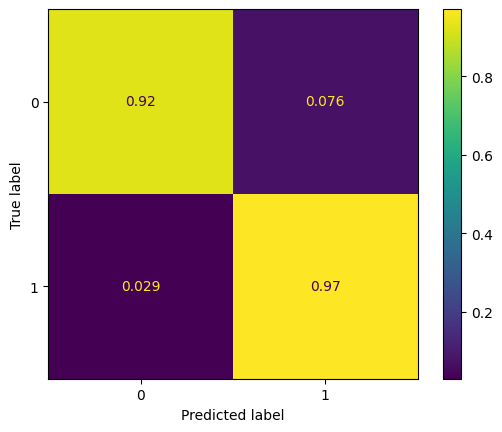

In [44]:
# Train set Evaluation - Random Forest

y_pred_train = rf_pipe.predict(X_train)

print('Train - Random Forest')
print('')
print('Classification Report : \n', classification_report(y_train, y_pred_train))
print('')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_predictions(y_true=y_train,
                                                                            y_pred=y_pred_train,
                                                                            normalize='true'))

Test - Random Forest

Classification Report : 
               precision    recall  f1-score   support

           0       0.92      0.88      0.90      1417
           1       0.89      0.92      0.90      1416

    accuracy                           0.90      2833
   macro avg       0.90      0.90      0.90      2833
weighted avg       0.90      0.90      0.90      2833


Confusion Matrix      : 


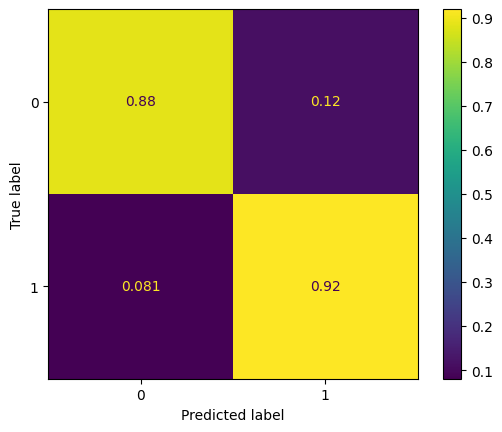

In [ ]:
# Test set Evaluation - Random Forest

y_pred_test = rf_pipe.predict(X_test)

print('Test - Random Forest')
print('')
print('Classification Report : \n', classification_report(y_test, y_pred_test))
print('')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                                                            y_pred=y_pred_test,
                                                                            normalize='true'))

Dari hasil prediksi menggunakan model Random Forest, didapatkan model tersebut dapat memprediksi penggunaan kupon diskon dengan akurasi kurang lebih 90% menurut F1 Score-nya. Model sedikit overfitting karena hasil train set sedikit lebih baik dibandingkan hasil test set, namun model cukup good fit dan dapat memprediksi data dengan baik.

Dalam mengevaluasi model, digunakan F1 Score karena mengurangi False Positive (kupon yang tidak digunakan dianggap digunakan) dan False Negative (kupon yang digunakan dianggap tidak digunakan) sama-sama penting dalam memprediksi penggunaan kupon diskon, sehingga dapat diperkirakan kupon diskon seperti apa yang lebih disukai atau sering digunakan oleh pelanggan.

## 8.3 Improve Random Forest Model with Hyperparameter Tuning

In [ ]:
# Melihat hyperparameter terbaik model Random Forest menggunakan Grid Search

param_grid = {
    'random_forest__n_estimators': [50, 100, 150, 200, 250],
    'random_forest__max_depth': [None, 10, 20, 25, 30, 35],
    'random_forest__min_samples_split': [1, 2, 3, 4, 5],
    'random_forest__min_samples_leaf': [1, 2, 3, 4, 5],
    'random_forest__bootstrap': [True, False]
    }

rf_grid = GridSearchCV(estimator=rf_pipe,
                          param_grid=param_grid,
                          cv=3,
                          n_jobs=-1,
                          verbose=3,
                          scoring='f1')

rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 1500 candidates, totalling 4500 fits


In [135]:
# Hyperparameter terbaik hasil Grid Search
rf_grid.best_params_

{'random_forest__bootstrap': True,
 'random_forest__max_depth': 20,
 'random_forest__min_samples_leaf': 1,
 'random_forest__min_samples_split': 3,
 'random_forest__n_estimators': 250}

In [136]:
# Model dengan hyperparameter terbaik hasil Grid Search
rf_grid_model = rf_grid.best_estimator_
rf_grid_model

Pipeline(steps=[('pre-processing',
                 Pipeline(steps=[('capping',
                                  Winsorizer(capping_method='iqr', fold=1.5,
                                             tail='both',
                                             variables='campaign_length')),
                                 ('encoder',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('nominal',
                                                                   OneHotEncoder(),
                                                                   ['brand_type',
                                                                    'campaign_type']),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Dairy, '
                                                                                               'Juices '
                                                                                               '& '
                                                                                               'Snacks',
                                                                                               'Grocery',
                                                                                               'Se...
                                                                                               'Meat',
                                                                                               'Meat',
                                                                                               'Pharmaceutical',
                                                                                               'Natural '
                                                                                               'Products',
                                                                                               'Skin '
                                                                                               '& '
                                                                                               'Hair '
                                                                                               'Care',
                                                                                               'Flowers '
                                                                                               '& '
                                                                                               'Plants',
                                                                                               'Garden',
                                                                                               'Travel',
                                                                                               'Miscellaneous',
                                                                                               'Bakery',
                                                                                               'Vegetables '
                                                                                               '(cut)',
                                                                                               'Salads'],
                                                                                              ['36-45',
                                                                                               '46-55',
                                                                                               '26-35',
                                                                                               '56-70',
                                                                                               '70+',
                                       

Train - Random Forest

Classification Report : 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      5665
           1       0.93      0.97      0.95      5666

    accuracy                           0.95     11331
   macro avg       0.95      0.95      0.95     11331
weighted avg       0.95      0.95      0.95     11331


Confusion Matrix      : 


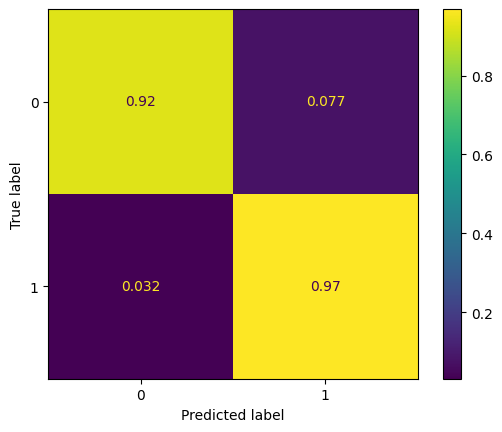

In [138]:
# Hyperparameter Tuning Evaluation

# Evaluation on Train Set
y_pred_train_grid = rf_grid_model.predict(X_train)

print('Train - Random Forest')
print('')
print('Classification Report : \n', classification_report(y_train, y_pred_train_grid))
print('')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_predictions(y_true=y_train,
                                                                            y_pred=y_pred_train_grid,
                                                                            normalize='true'))

Test - Random Forest

Classification Report : 
               precision    recall  f1-score   support

           0       0.92      0.88      0.90      1417
           1       0.89      0.92      0.90      1416

    accuracy                           0.90      2833
   macro avg       0.90      0.90      0.90      2833
weighted avg       0.90      0.90      0.90      2833


Confusion Matrix      : 


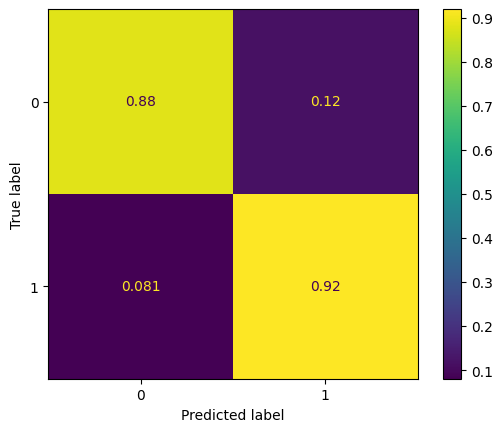

In [139]:
# Evaluation on Test Set

y_pred_test_grid = rf_grid_model.predict(X_test)

print('Test - Random Forest')
print('')
print('Classification Report : \n', classification_report(y_test, y_pred_test_grid))
print('')
print('Confusion Matrix      : \n', ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                                                            y_pred=y_pred_test_grid,
                                                                            normalize='true'))

## 8.4 Finalizing Prediction Model

Hasil dari hyperparameter tuning model Random Forest menghasilkan hasil yang kurang lebih sama dengan baseline model Random Forest. Maka model yang akan digunakan untuk memprediksi penggunaan kupon diskon adalah baseline model Random Forest.

# 9. Model Saving

In [21]:
with open('model.pkl','wb') as model:
  pickle.dump(rf_pipe,model)

# 10. Kesimpulan

Untuk memprediksi apakah kupon digunakan dalam suatu transaksi yang dilakukan oleh seorang pelanggan, dapat digunakan informasi mengenai besarnya diskon yang didapatkan dari kupon tersebut,lamanya periode promosi,tanggal transaksi, tanggal mulai dan berakhirnya promosi, tipe brand yang diberikan promosi, apakah brand tersebut merupakan brand established atau lokal, kategori barang yang dipromosikan, tipe campaign atau promosi, kelompok umur dari pelanggan, dan tingkat pendapatan pelanggan.

Dengan menggunakan model Random Forest, didapatkan model yang dapat memprediksi penggunaan suatu kupon promosi dengan akurasi sekitar 90%.

Untuk meningkatkan pembelajaran model, perlu ditambahkan jenis barang selain dari barang grocery atau barang kebutuhan sehari-hari, sehingga lebih terlihat perilaku konsumsi dari berbagai kalangan pelanggan.